# Labs Access Analysis: 03 City Map Plot

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import json
pd.options.mode.chained_assignment = None
import branca.colormap as cmp
import os
import time
import folium
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import colorcet as cc

In [2]:
sns.set_context("poster")
sns.set_style("ticks")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [3]:
url_data_labs = "data/valid_labs.csv"
url_data_isochrones = "data/isochrones.json"

In [4]:
# Load data, json
with open(url_data_isochrones) as json_file:
    data = json.load(json_file)

In [5]:
# Load data, csv
labs = pd.read_csv(url_data_labs)

In [6]:
locations = {}
for i in data:
  locations[i['name']] = i['metadata']['query']['locations'][0]

### Select only City labs, not the full Metropolitan Area

In [7]:
searchfor = ['Barcelona', 'Milano']
city_labs = labs[labs.City.str.contains('|'.join(searchfor))]

In [8]:
city_labs.head()

Unnamed: 0                                   Name                   Type  \
0           0                           3D Incubator  Incubator-Accelerator   
1           1                   AKASHA Hub Barcelona            Hackerspace   
2           2        Ateneu de Fabricació Ca L'Alier   Ateneu de Fabricació   
3           3  Ateneu de Fabricació Ciutat Meridiana   Ateneu de Fabricació   
4           4            Ateneu de Fabricació Gràcia   Ateneu de Fabricació   

        City Cluster                                            Address  \
0  Barcelona     BCN  Polígono Industrial de la, Avinguda Parc Logís...   
1  Barcelona     BCN                      carrer de la verneda, 17 loc1   
2  Barcelona     BCN                             Carrer de Pere IV, 362   
3  Barcelona     BCN                       Av. de Rasos de Peguera, 232   
4  Barcelona     BCN                                    Carrer Perill 8   

      CAP        Lat      Long                    Source  \
0  8040.0  41.340036  2.123036            Manually added   
1  8018.0  41.411054  2.191146          Hackerspaces.org   
2  8019.0  41.410786  2.203873  Ajuntament.barcelona.cat   
3  8033.0  41.460460  2.169872  Ajuntament.barcelona.cat   
4  8012.0  41.399364  2.161167  Ajuntament.barcelona.cat   

                                                 URL Notes URL 2  
0                       https://www.incubator3d.org/   NaN   NaN  
1  https://wiki.hackerspaces.org/AKASHA_Hub_Barce...   NaN   NaN  
2                                                NaN   NaN   NaN  
3  https://ajuntament.barcelona.cat/ateneusdefabr...   NaN   NaN  
4  https://ajuntament.barcelona.cat/ateneusdefabr...   NaN   NaN

In [9]:
closed_labs = city_labs[city_labs.Notes.str.contains("losed")==True]
city_labs = city_labs[~city_labs.index.isin(closed_labs.index)]

In [10]:
locations = {}
for i in data:
    if (i['name'] in city_labs["Name"].values):
        locations[i['name']] = i['metadata']['query']['locations'][0]

In [11]:
# Remove the metropolital labs from the isochrones data
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)
        
# One lab is not removed at first iteration??
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)

Removed BDN Lab
Removed DamASpace
Removed Disseny Lab UAB
Removed EspluLab
Removed Fab Lab Sant Cugat
Removed FabLabMilano - Fare le Idee / ShapeMode / Locanda Officina Monumentale
Removed Green Fab Lab
Removed Kinlab
Removed Makers Hub
Removed Milano Luiss Hub
Removed Multilab Rozzano
Removed Polifactory
Removed Recipient
Removed SuperForma Lab
Removed The FabLab: Make in Milano
Removed Vectorealism FabLab
Removed WeMake | Makerspace Fablab
Removed +Lab Politecnico di Milano
Removed Rete Nema
Removed HP 3D Printing and Digital Manufacturing Center of Excellence
Removed Laboratorio Creativo Metropolitano
Removed Miocugino - officina di gesta e ingegno
Removed Politecnico Open unix Labs
Removed Share Makerspace
Removed TECHINNOVA S.P.A.
Removed W!LAB
Removed MaBa.SAPERLab Politecnico di Milano


### Map visualziation

In [12]:
m=folium.Map(location=[41.396721,2.1943200000000003])
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)

In [13]:
for loc in locations:
  folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(m)

In [14]:
m

organize the data

In [15]:
rows = []
for h in data:
  rows.append([h["name"], h["features"][0]["properties"]["total_pop"], h["features"][0]["properties"]["area"], h["features"][0]["properties"]["reachfactor"], h["features"][0]["geometry"]["coordinates"], []])

In [16]:
map_data = pd.DataFrame(rows, columns=['Name', 'total_pop', 'area', 'reachfactor','geometry', 'isochrone'])
map_data.head()

Name  total_pop        area  reachfactor  \
0                           3D Incubator    25847.0  1257375.85       0.2562   
1                   AKASHA Hub Barcelona    96774.0  4573263.53       0.9317   
2        Ateneu de Fabricació Ca L'Alier    93219.0  4526884.39       0.9222   
3  Ateneu de Fabricació Ciutat Meridiana    11587.0  1595247.01       0.3250   
4            Ateneu de Fabricació Gràcia    97329.0  4510074.18       0.9188   

                                            geometry isochrone  
0  [[[2.109858, 41.336682], [2.111475, 41.334295]...        []  
1  [[[2.178987, 41.413062], [2.179193, 41.408718]...        []  
2  [[[2.190682, 41.404717], [2.192169, 41.402302]...        []  
3  [[[2.162366, 41.467182], [2.162393, 41.466976]...        []  
4  [[[2.148282, 41.39726], [2.148285, 41.397202],...        []

create a flip isochrone cell for each lab

In [17]:
for ind in map_data.index:
     row_iso = []
     for coords in map_data['geometry'][ind][0]:
       row_iso.append([coords[1], coords[0], 900])
     map_data.at[ind, 'isochrone'] = row_iso

In [18]:
map_data.set_index('Name', inplace=True)
labs.set_index('Name', inplace=True)

add colums from the csv file (the labs) to the json file (the isochrones)

In [19]:
full_map_data = map_data.join(labs)

In [20]:
full_map_data

total_pop        area  \
Name                                                                        
3D Incubator                                          25847.0  1257375.85   
AKASHA Hub Barcelona                                  96774.0  4573263.53   
Ateneu de Fabricació Ca L'Alier                       93219.0  4526884.39   
Ateneu de Fabricació Ciutat Meridiana                 11587.0  1595247.01   
Ateneu de Fabricació Gràcia                           97329.0  4510074.18   
Ateneu de Fabricació La Fàbrica del Sol / Espai...    48218.0  2807067.38   
Ateneu de Fabricació Les Corts                        88373.0  4220282.63   
Ateneu de Fabricació Parc Tecnológic                  83897.0  4259804.83   
ATTA33                                                93252.0  4657447.19   
Barcelona Mobility LAB                                44110.0  2136107.60   
Camins Makers                                         61277.0  3546987.51   
Cibernarium Poble Nou (Barcelona Activa)              94265.0  4334480.56   
Cibernarium Parc Tecnologic (Barcelona Activa)        82690.0  4300141.48   
Club Maker de l'American Space - Biblioteca Fab...    86930.0  4157972.07   
Danaus                                               100054.0  4859209.70   
DIY Bio Barcelona                                     99832.0  4525465.36   
EASD Llotja - Sant Andreu                             80707.0  3730175.23   
Elisava, Barcelona School of Design and Enginee...    76835.0  4623604.96   
Espai Jove Casa Sagnier                               94316.0  4550527.92   
Fab Lab Barcelona                                     86850.0  4437452.50   
FabCafé Barcelona                                     89397.0  4443699.41   
Fundació Avismón                                      94273.0  4532150.30   
Fundació CIM                                          77329.0  3994597.59   
Fundació Comtal                                       91473.0  4496023.88   
IAM3DHUB / Dfactory Barcelona                         28808.0  1150407.81   
LSCongres                                             95371.0  4499194.42   
MADE Makerspace Barcelona                             88740.0  4416421.99   
Maker Convent                                         87482.0  4383404.19   
Makers Zone BCN                                       86648.0  4476777.29   
Opendot                                               54632.0  4193280.21   
Punt Multimedia FAB Casa del Mig                      91882.0  4342148.62   
Punt Multimedia La Marina                             65902.0  3656085.89   
Punt Òmnia Casal Cívic Barcelona - Verdum - Fun...    69295.0  3882192.34   
Racó.net del Guinardó                                 91676.0  4592848.06   
RavalFab / Colectic                                  101992.0  4723762.22   
Soko Tech                                             91433.0  4354755.22   
TinkeringZone Maker space                             44822.0  3448109.56   
TMDC                                                  61950.0  3199320.67   
YATTA                                                 46825.0  4188902.97   
Fundació Pare Manel                                   68317.0  3879843.49   
Repair Cafè Lab Barona                                31641.0  4306361.89   
Repair Café Barcelona                                 84608.0  4006062.06   
Caixa d'Eines i Feines                                94125.0  4456935.84   
Millor que nou, reparat                               96884.0  4644675.49   
Biblioteca de les coses                               81613.0  4315092.39   
La Nau Vila Besòs                                     55802.0  2907897.11   
Casal del Barri del Clot Espai Antoni Miró Peri...    90377.0  4396516.69   
Banc de Recursos Mancomunats de Ciutat Vella          83347.0  4700917.48   
Vestuariteca                                          96662.0  4515345.33   
Fundació Banc de Recursos                             92136.0  4412564.07   

                                               

Transform the areas in square km


In [21]:
map_data["area"] = map_data["area"] / 1000000.0

In [22]:
map_data["area"].head()

Name
3D Incubator                             1.257376
AKASHA Hub Barcelona                     4.573264
Ateneu de Fabricació Ca L'Alier          4.526884
Ateneu de Fabricació Ciutat Meridiana    1.595247
Ateneu de Fabricació Gràcia              4.510074
Name: area, dtype: float64

### Population reached

plot the data

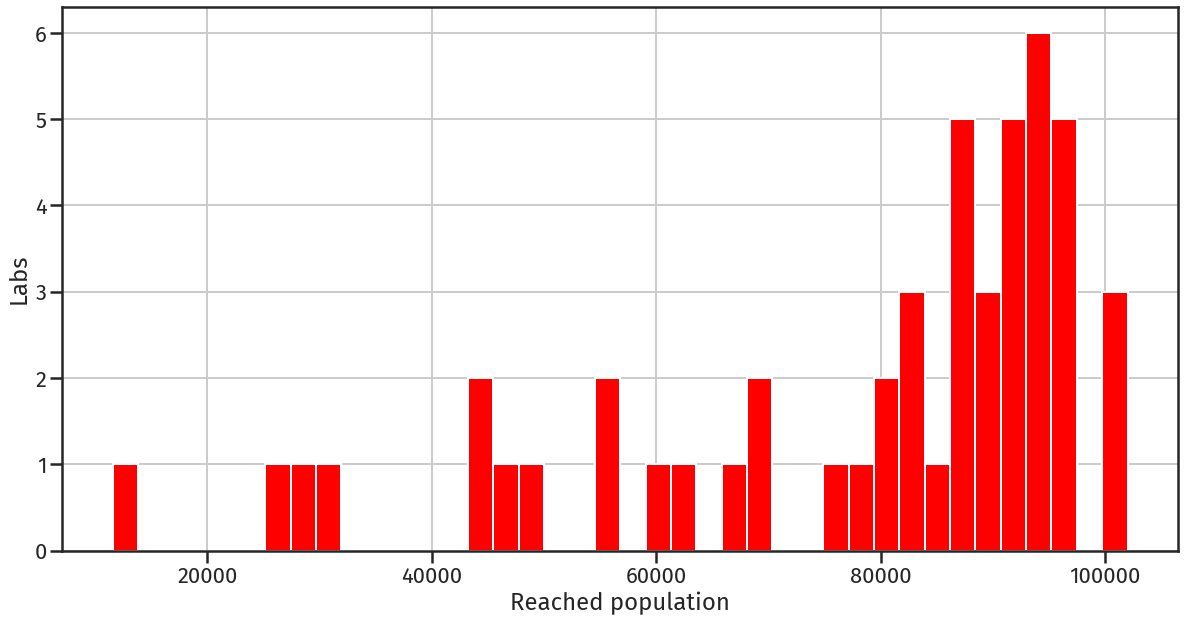

In [23]:
map_data["total_pop"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.grid()
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_population_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_hist.png", dpi=300, bbox_inches="tight")

plot the data of the population reached by each lab

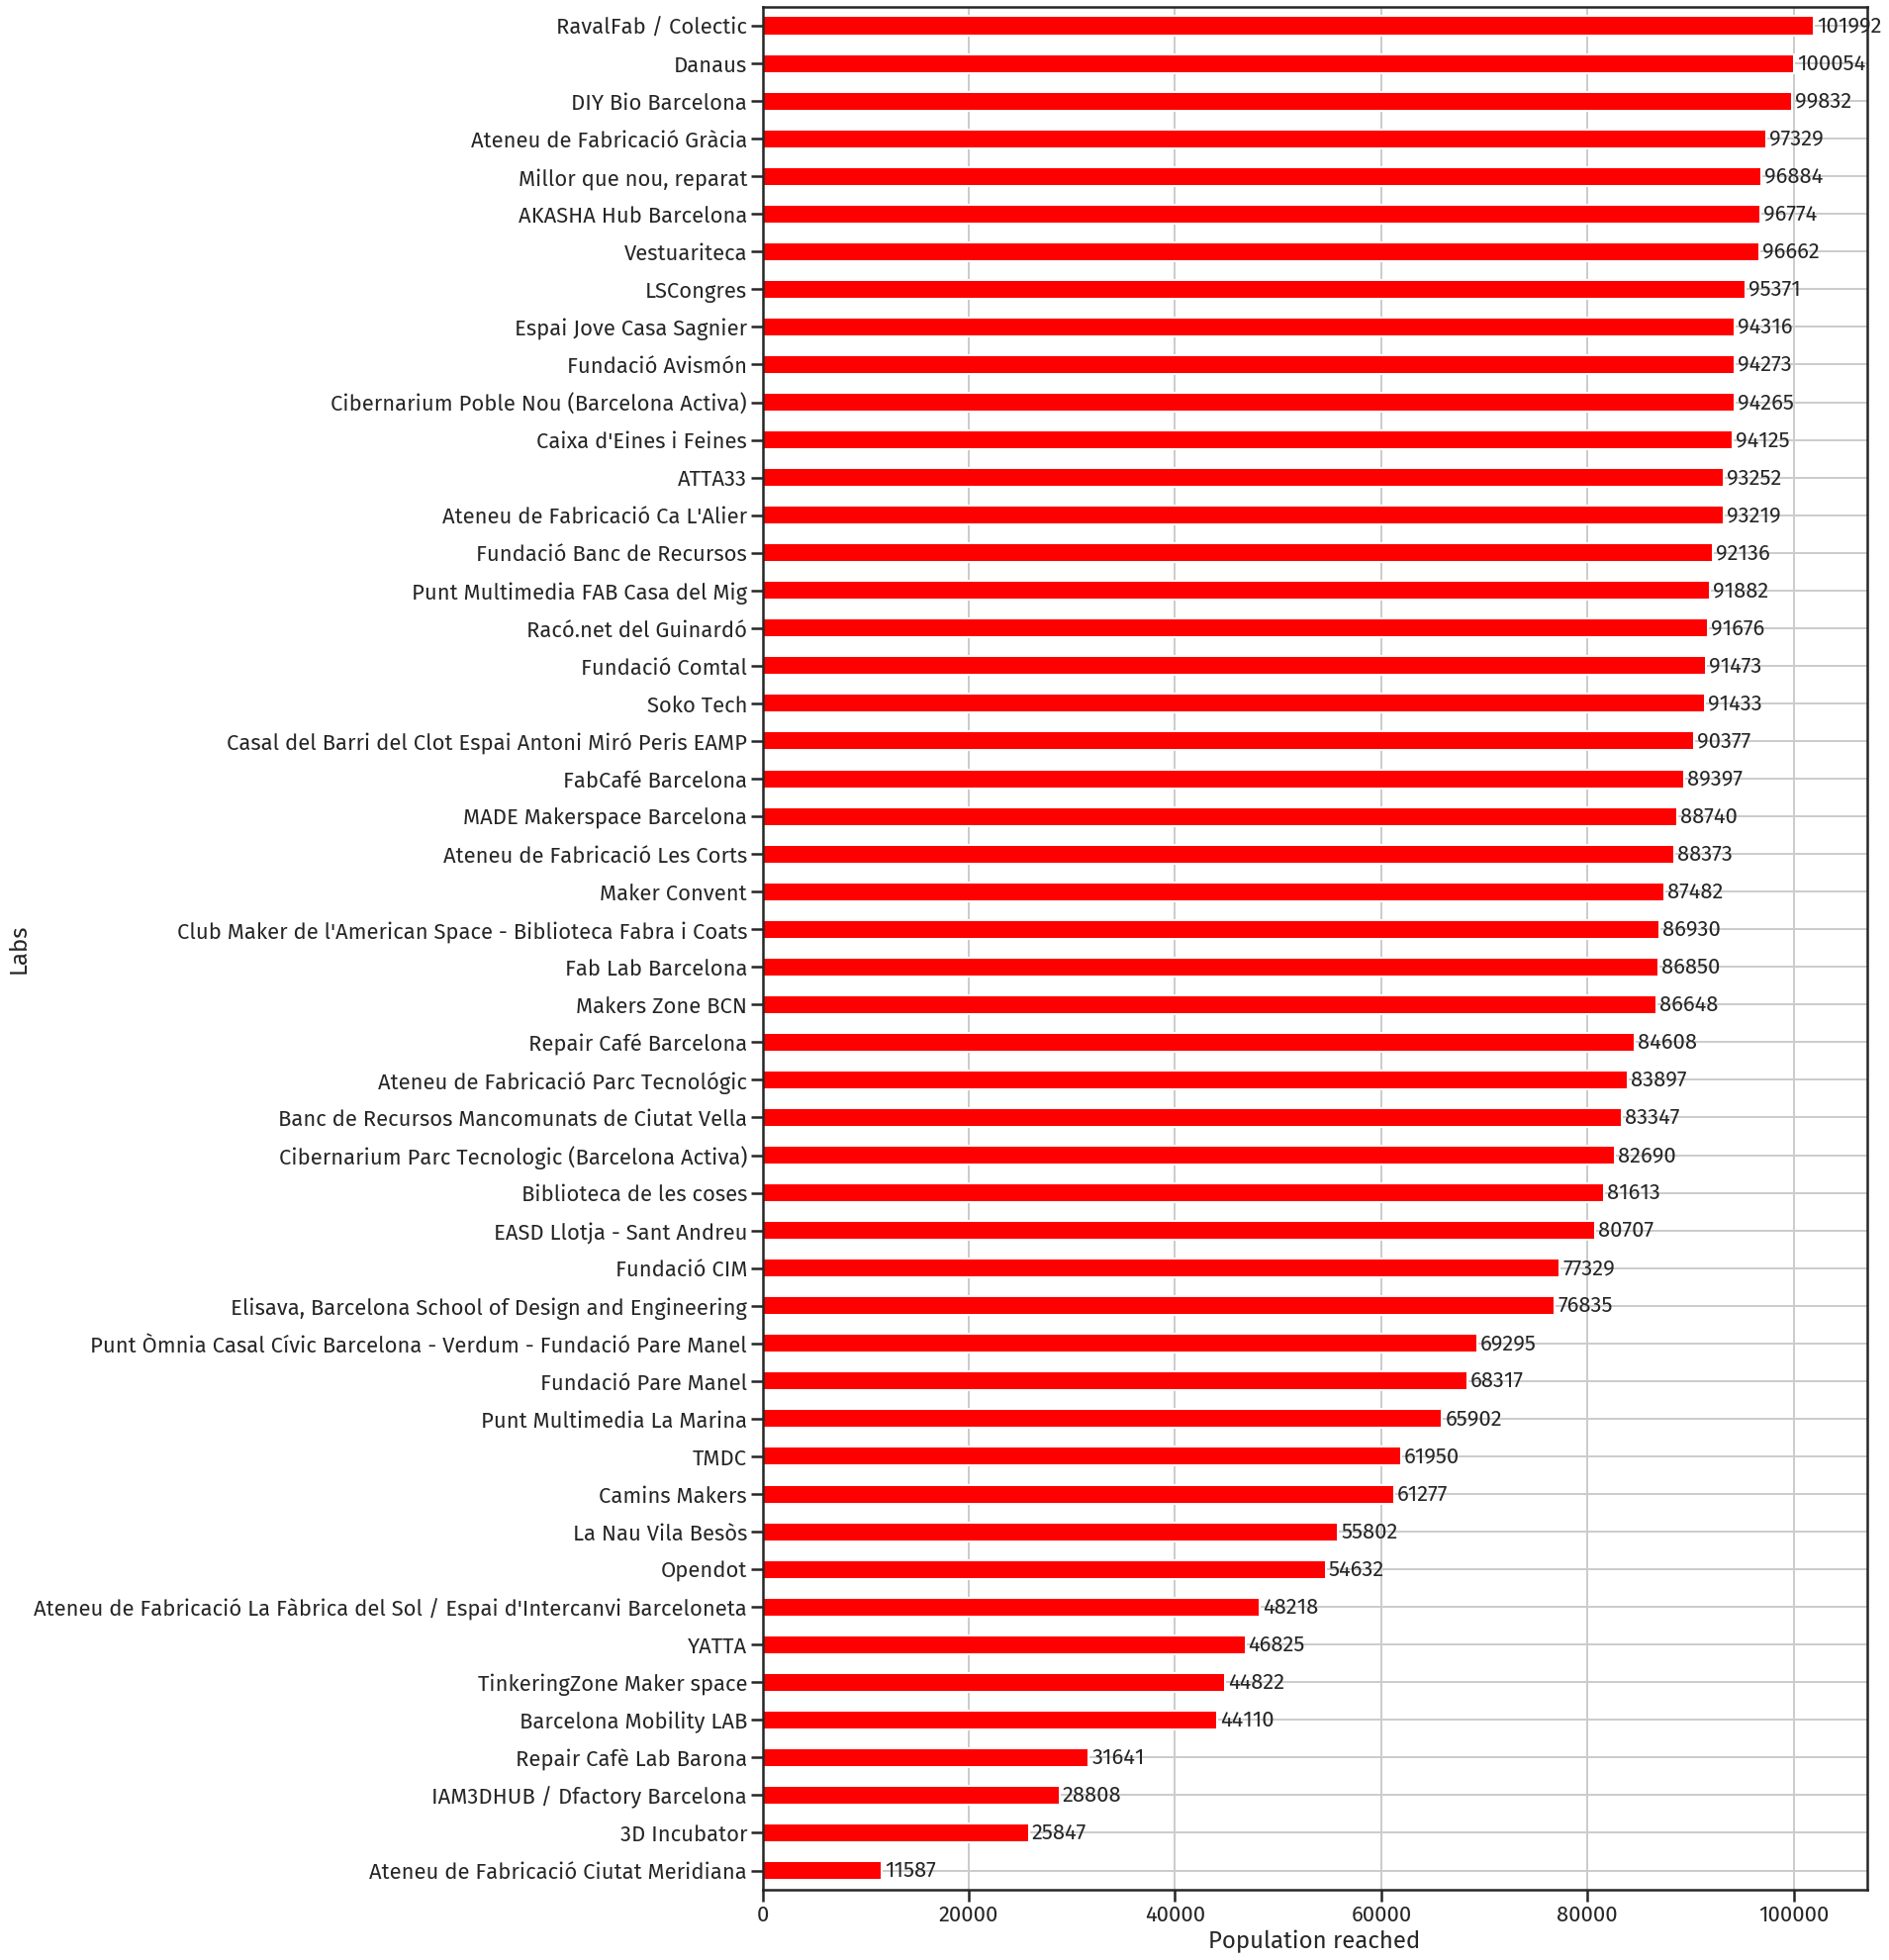

In [24]:
ax = map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_bar.png", dpi=300, bbox_inches="tight")

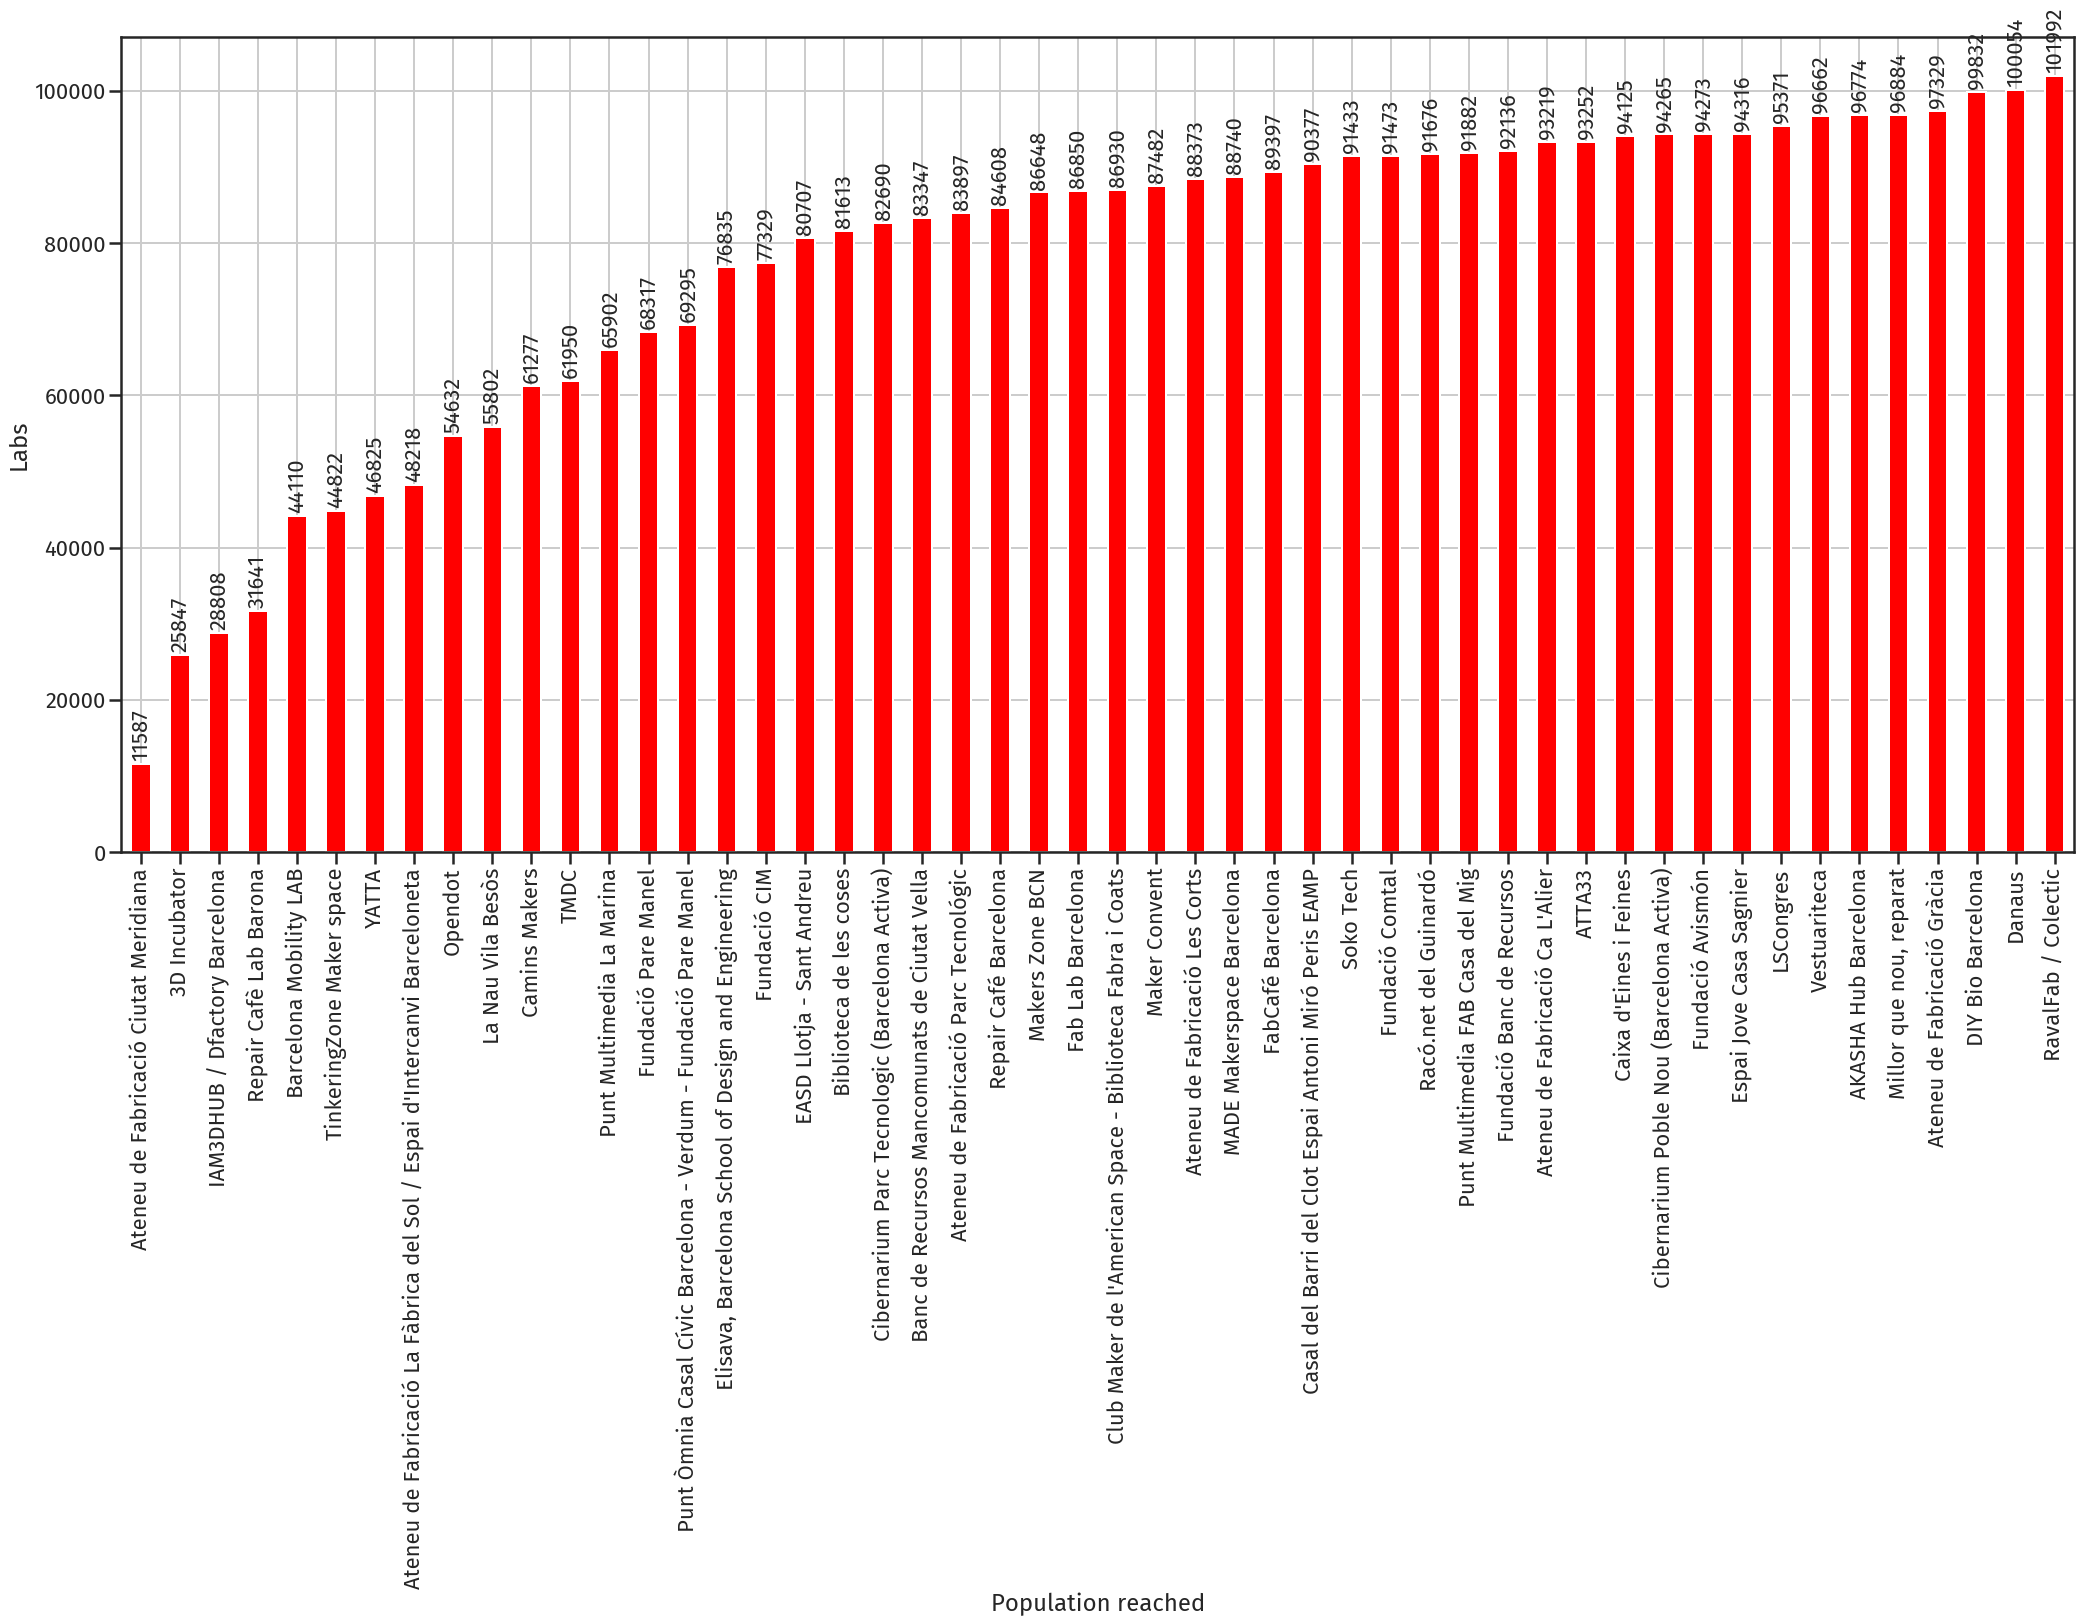

In [25]:
ax = map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3, rotation=90)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_bar_vertical.png", dpi=300, bbox_inches="tight")

### Area reached

Plot the data

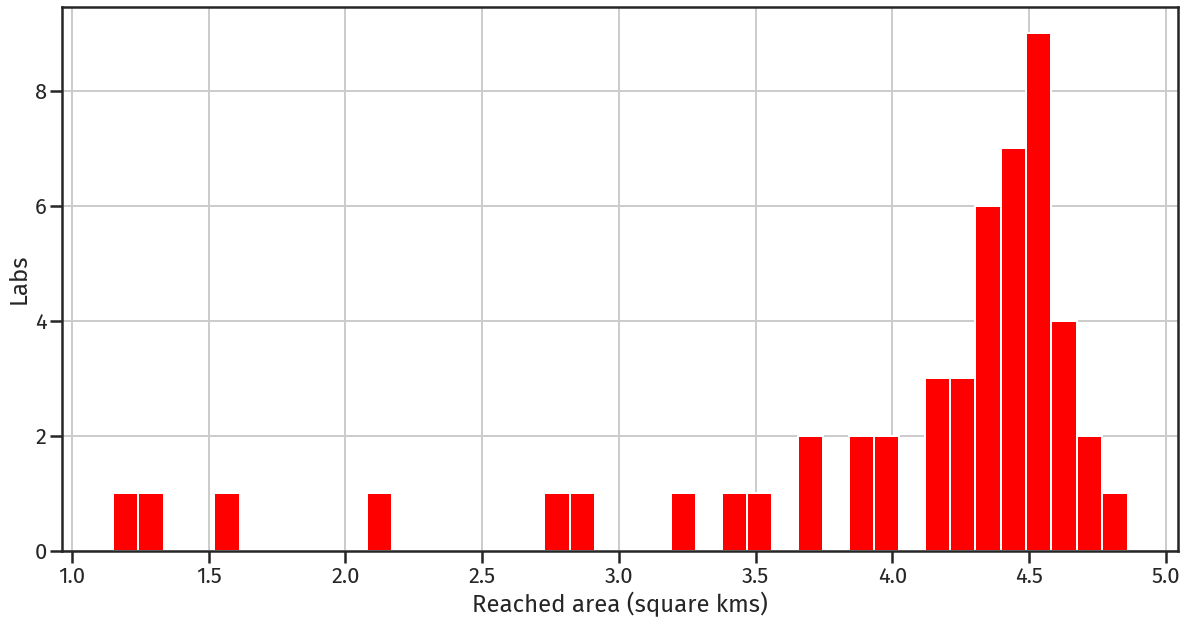

In [26]:
map_data["area"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_hist.png", dpi=300, bbox_inches="tight")

Plot the data of the area reached by each lab

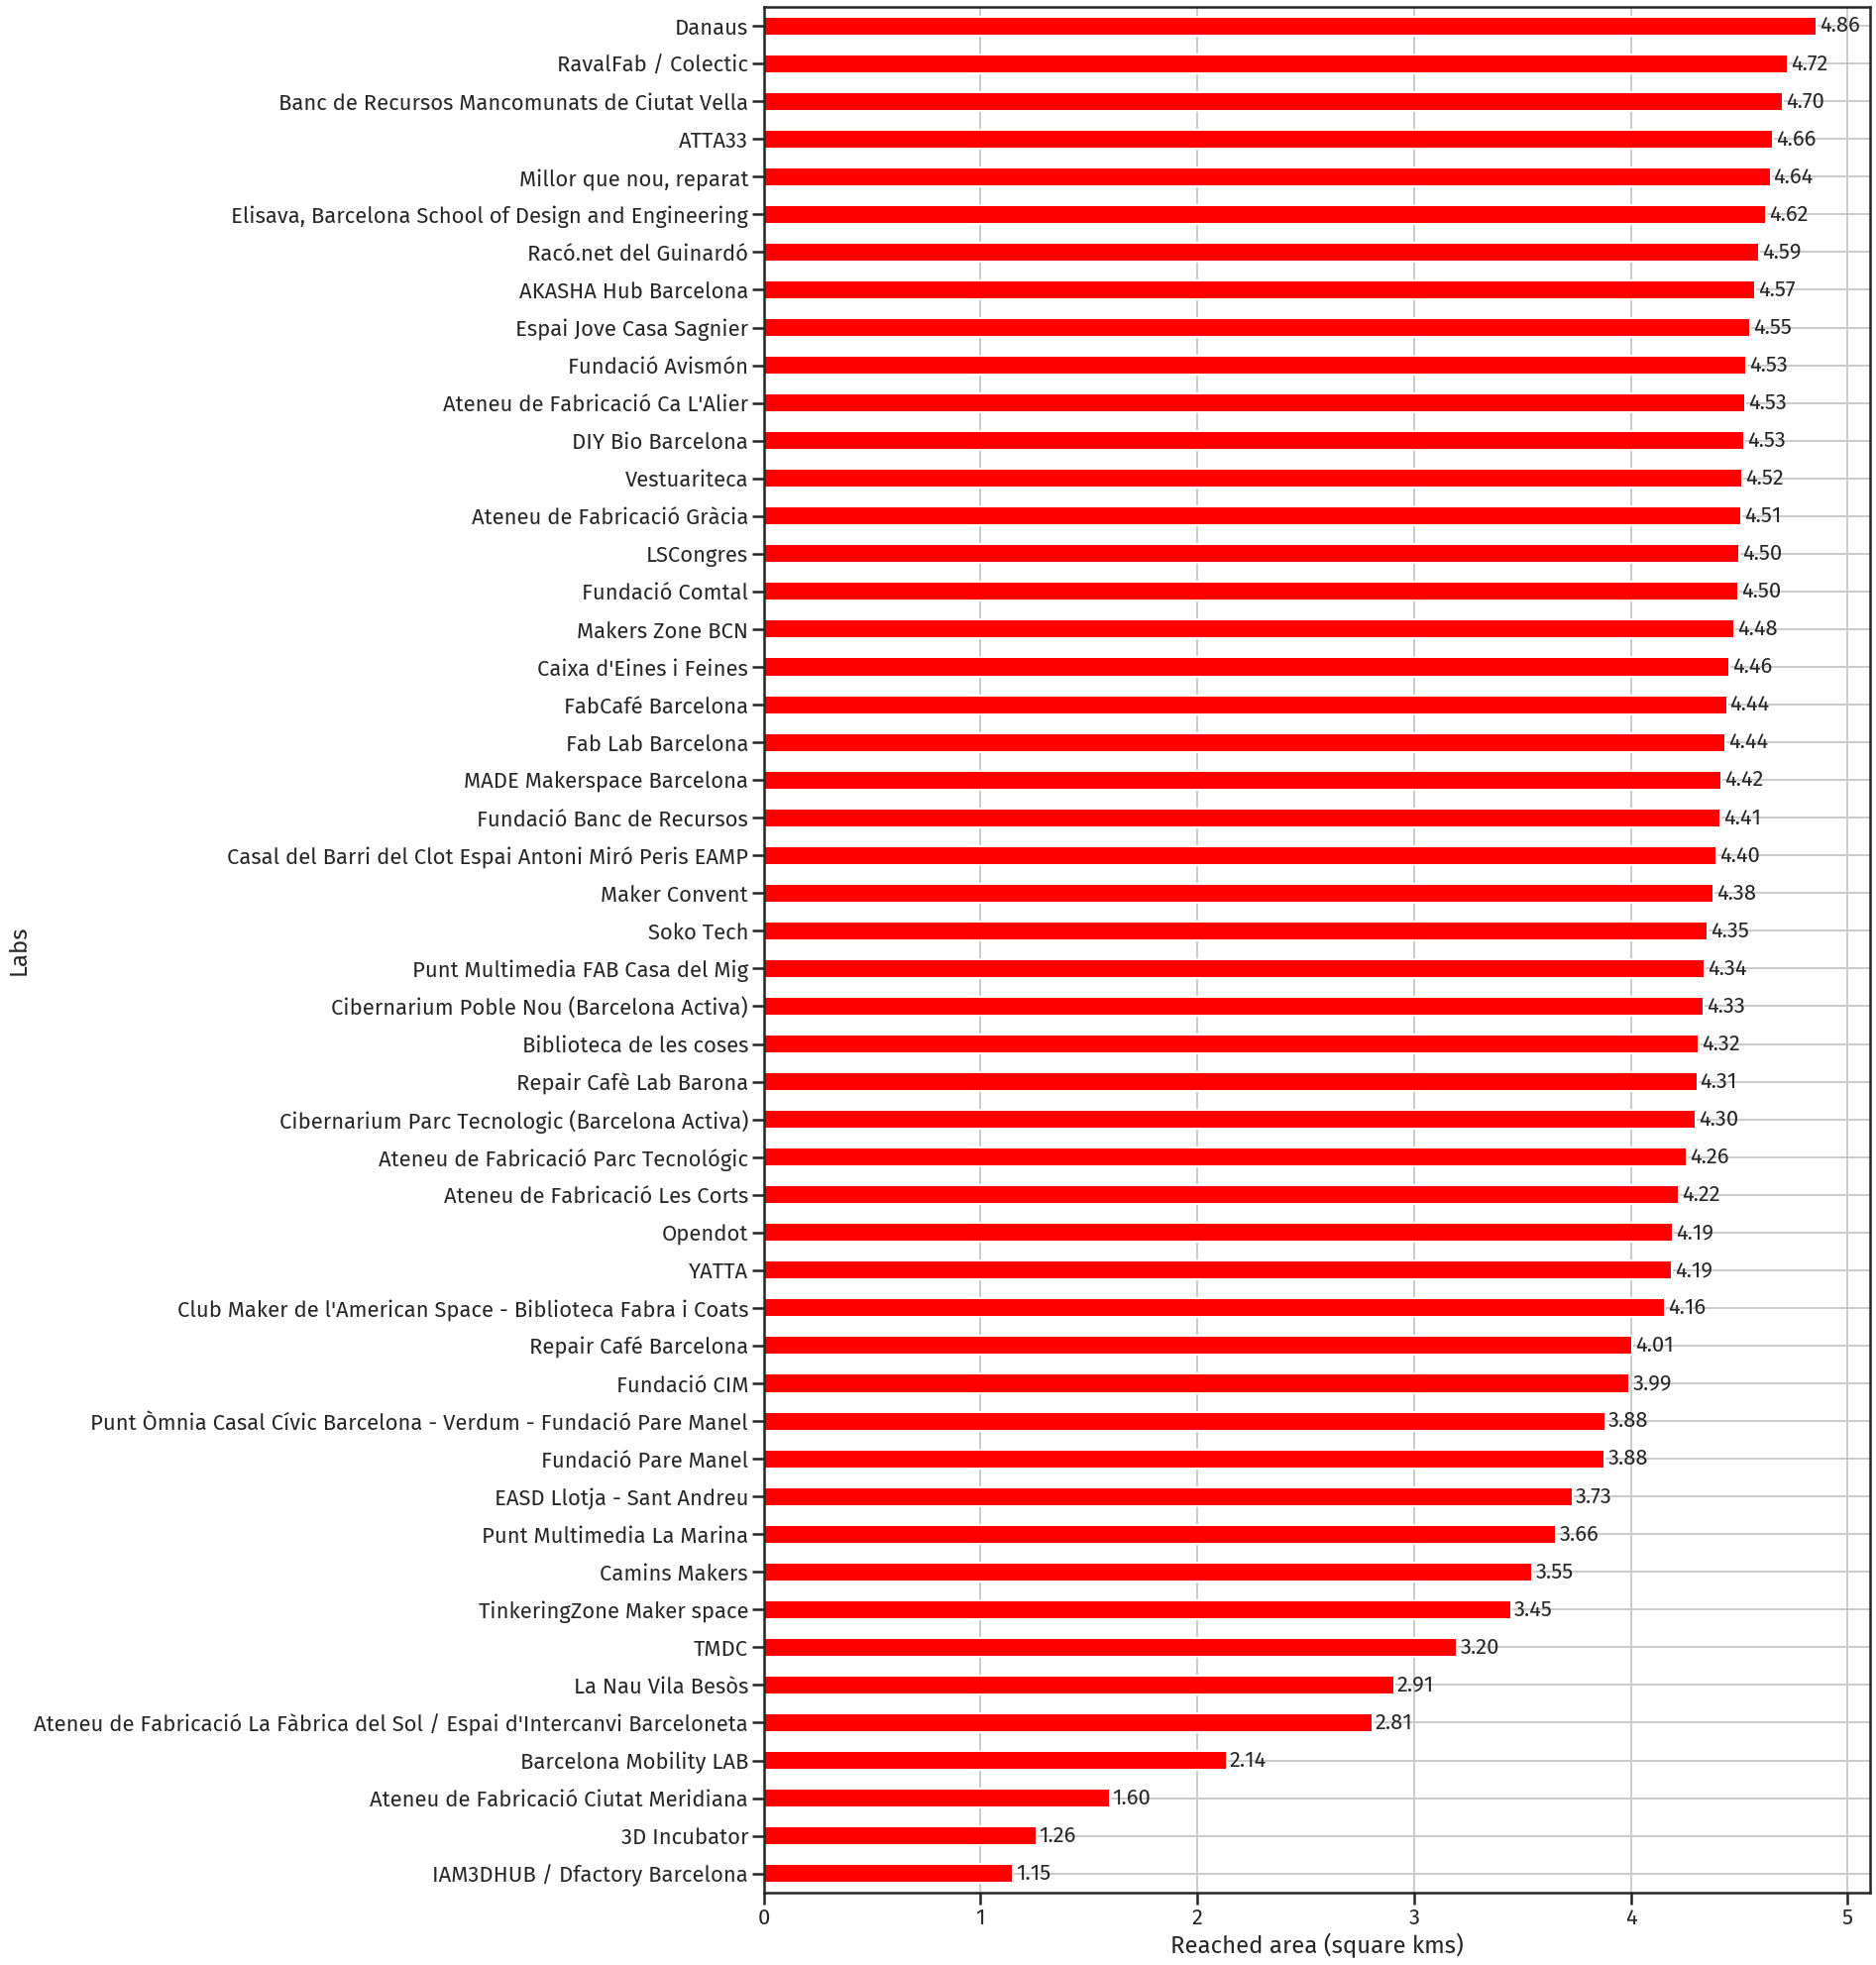

In [27]:
ax = map_data.sort_values(by=['area'])['area'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_bar.png", dpi=300, bbox_inches="tight")

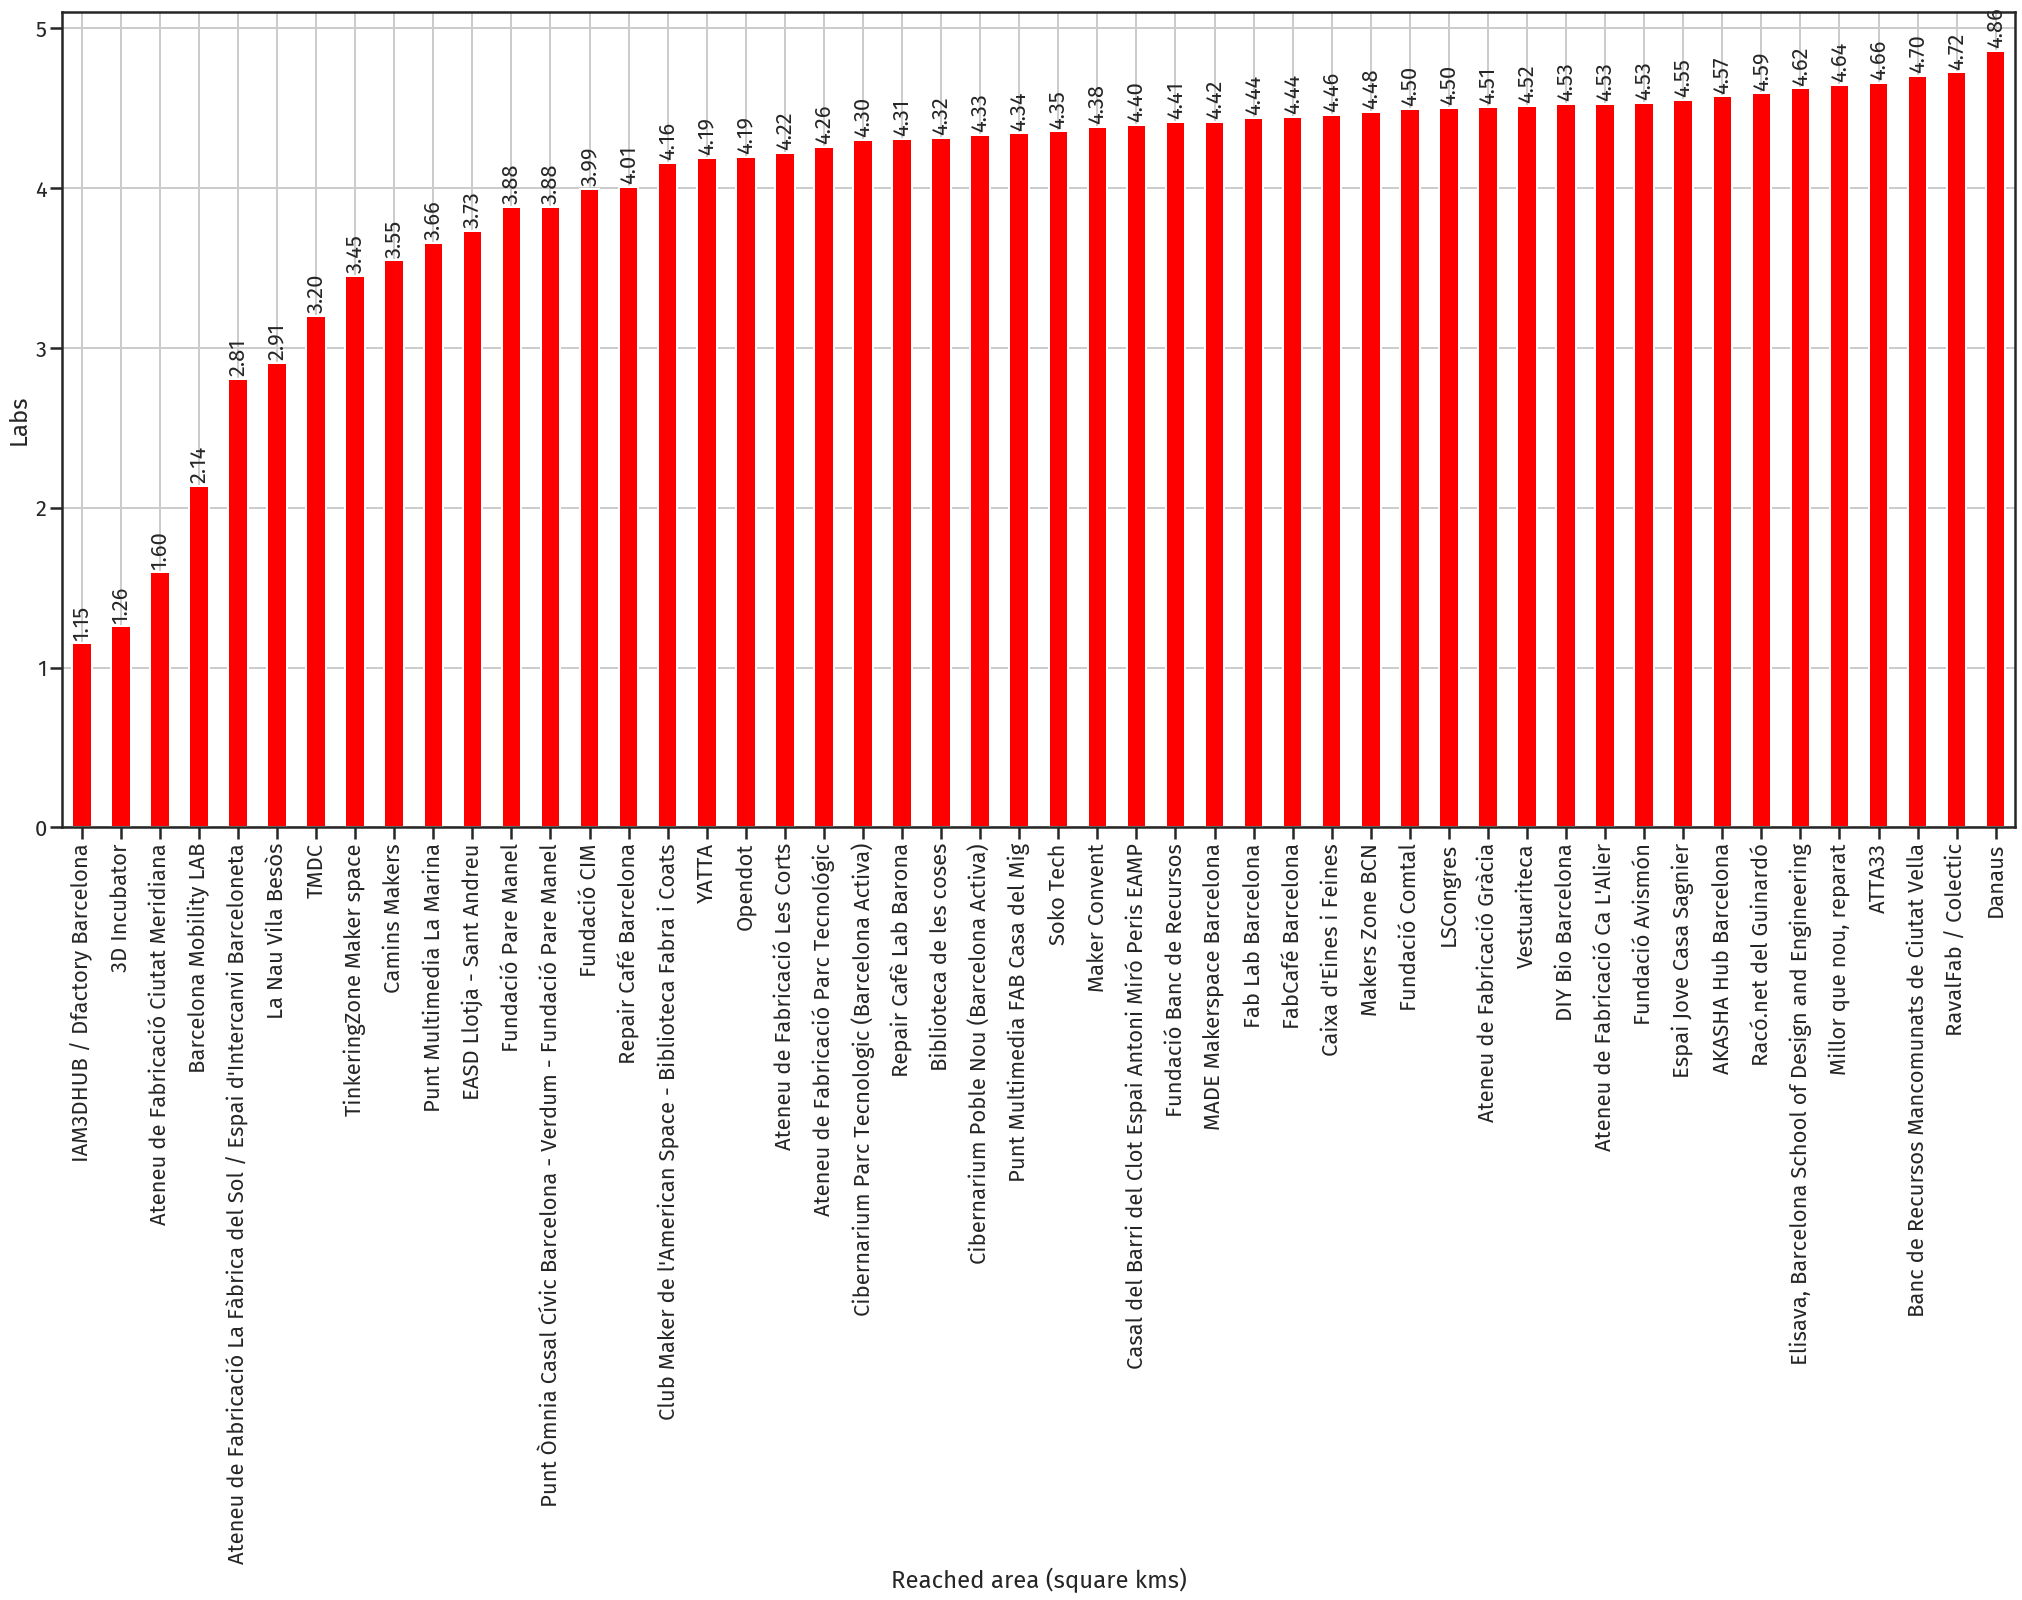

In [28]:
ax = map_data.sort_values(by=['area'])['area'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_bar_vertical.png", dpi=300, bbox_inches="tight")

### Reach Factor

Plot the data

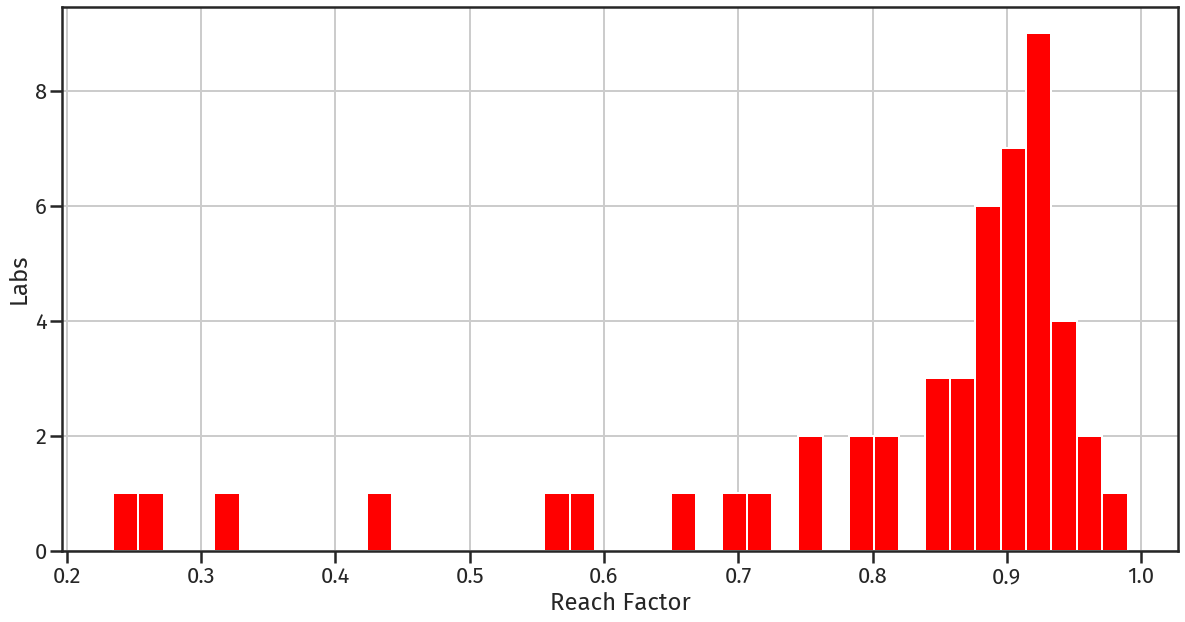

In [29]:
map_data["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_hist.png", dpi=300, bbox_inches="tight")

plot the data of the reach factor for each lab

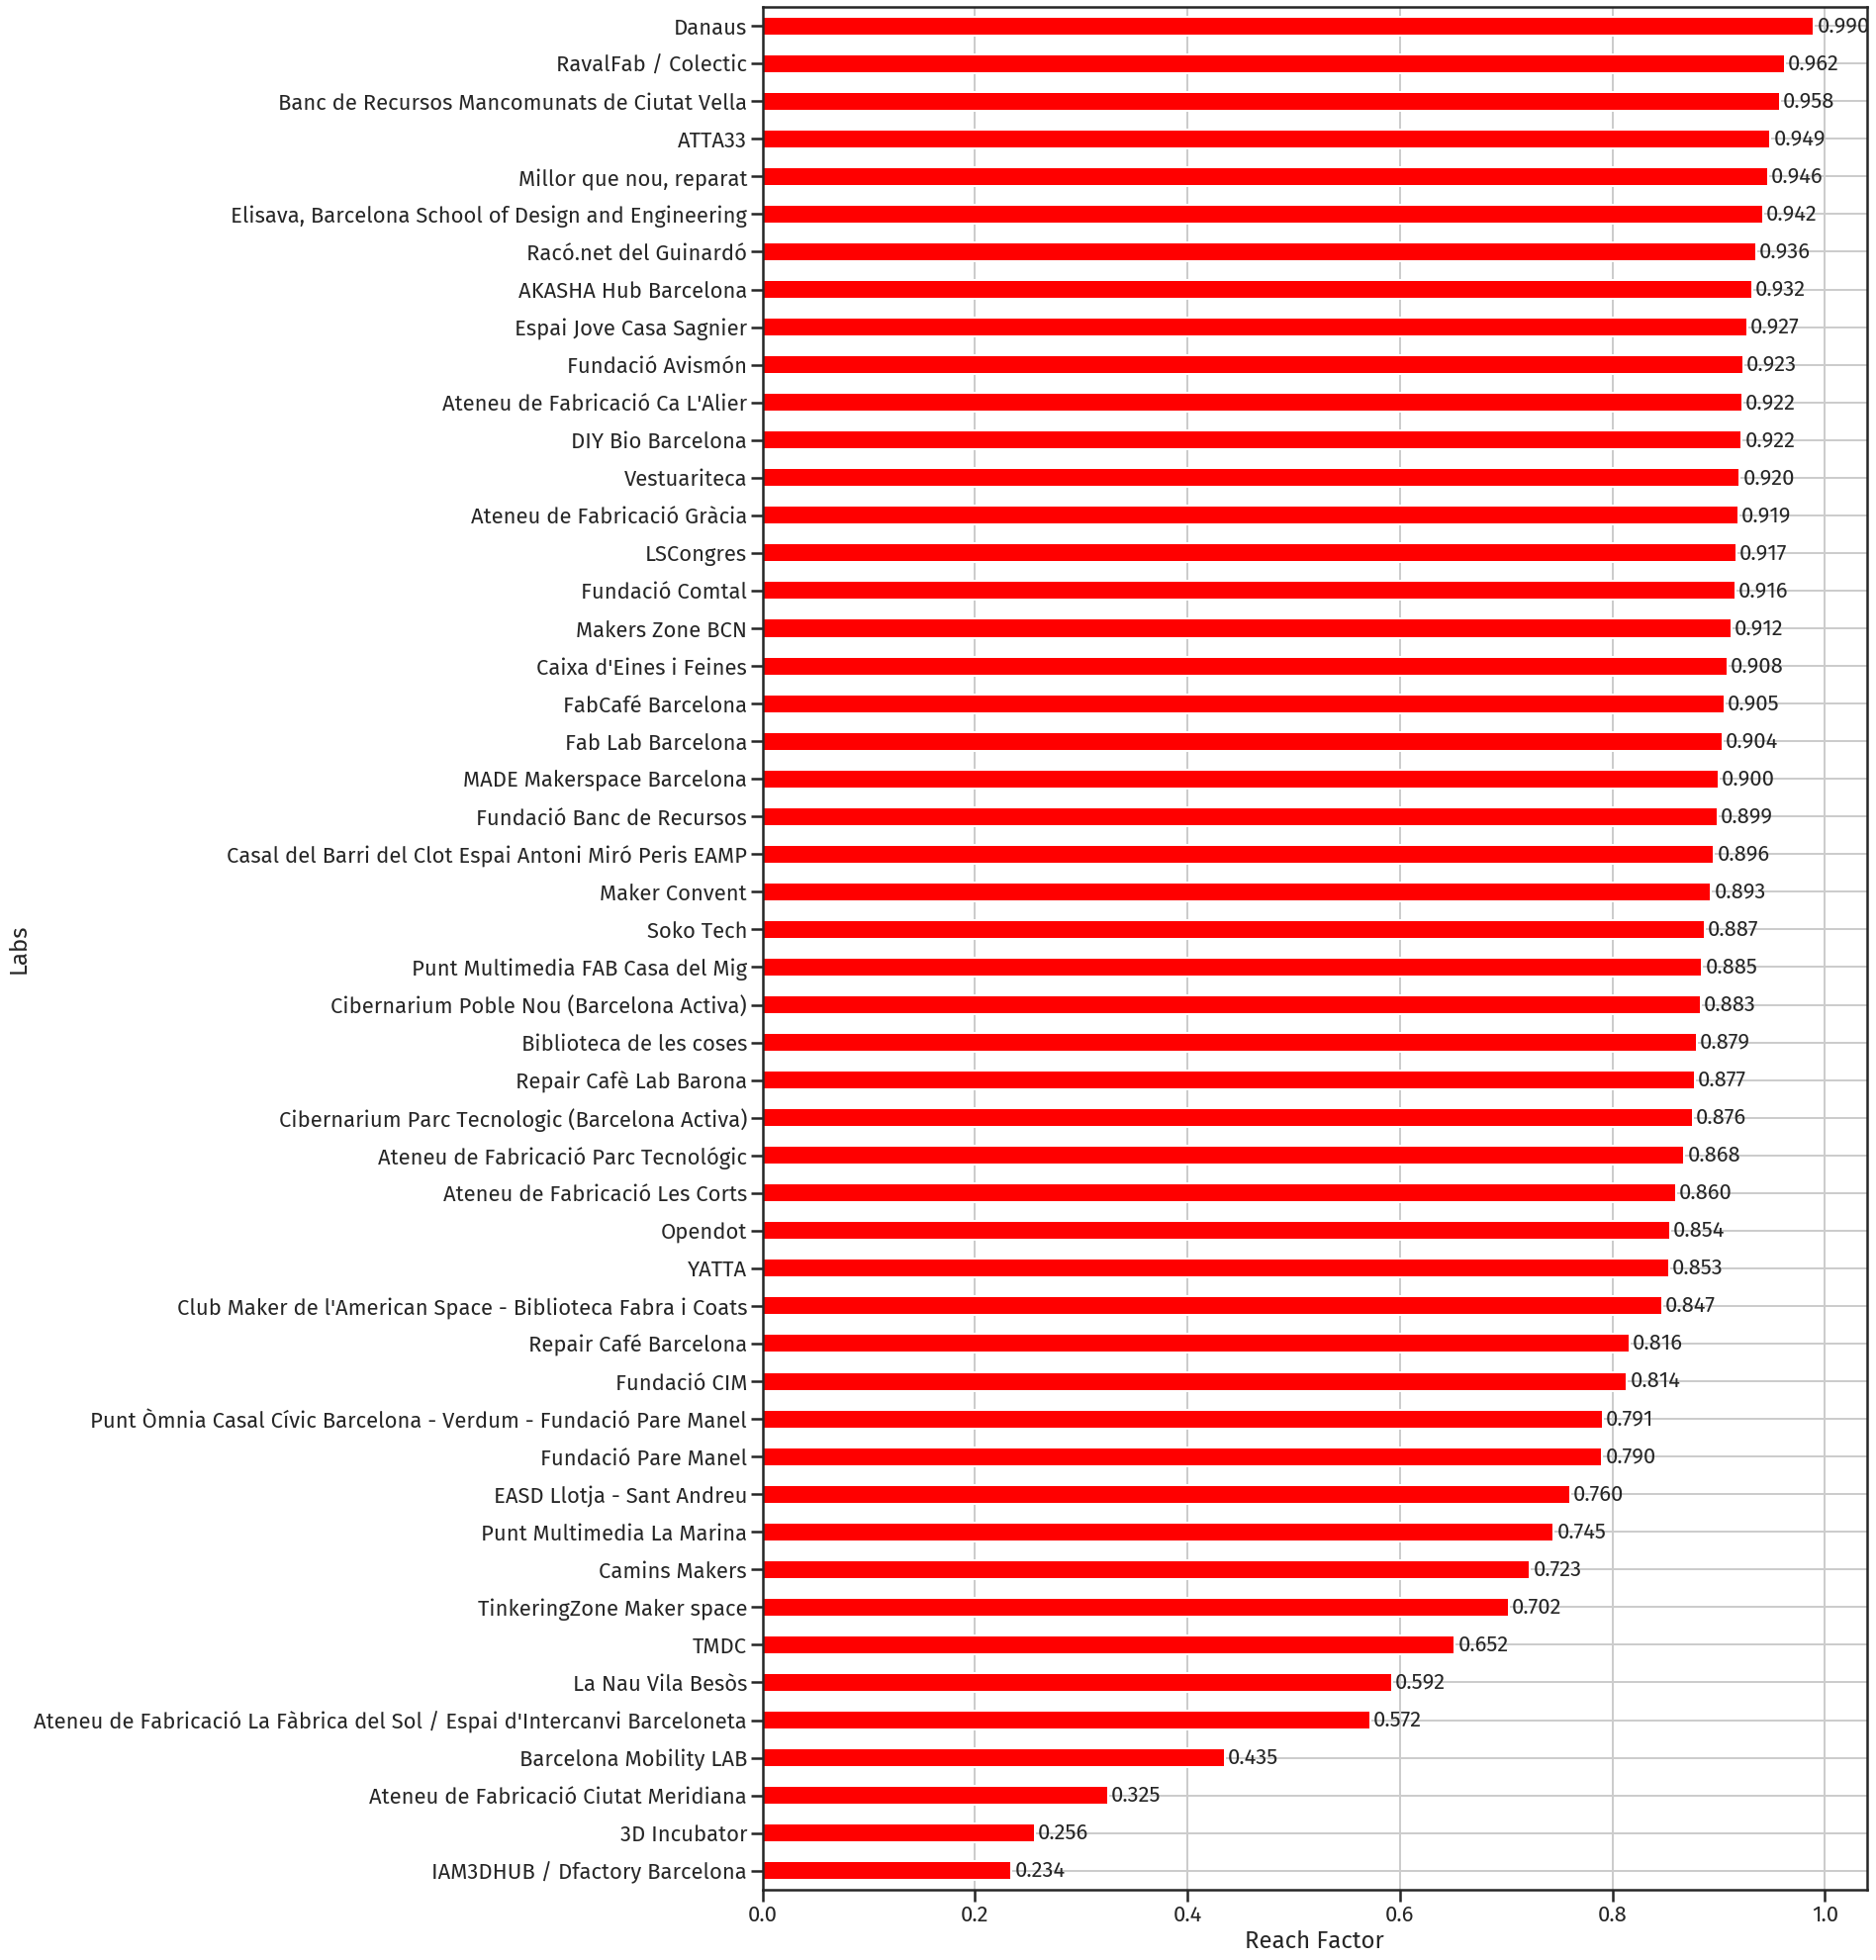

In [30]:
ax = map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%.3f", size=22, padding=3)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_bar.png", dpi=300, bbox_inches="tight")

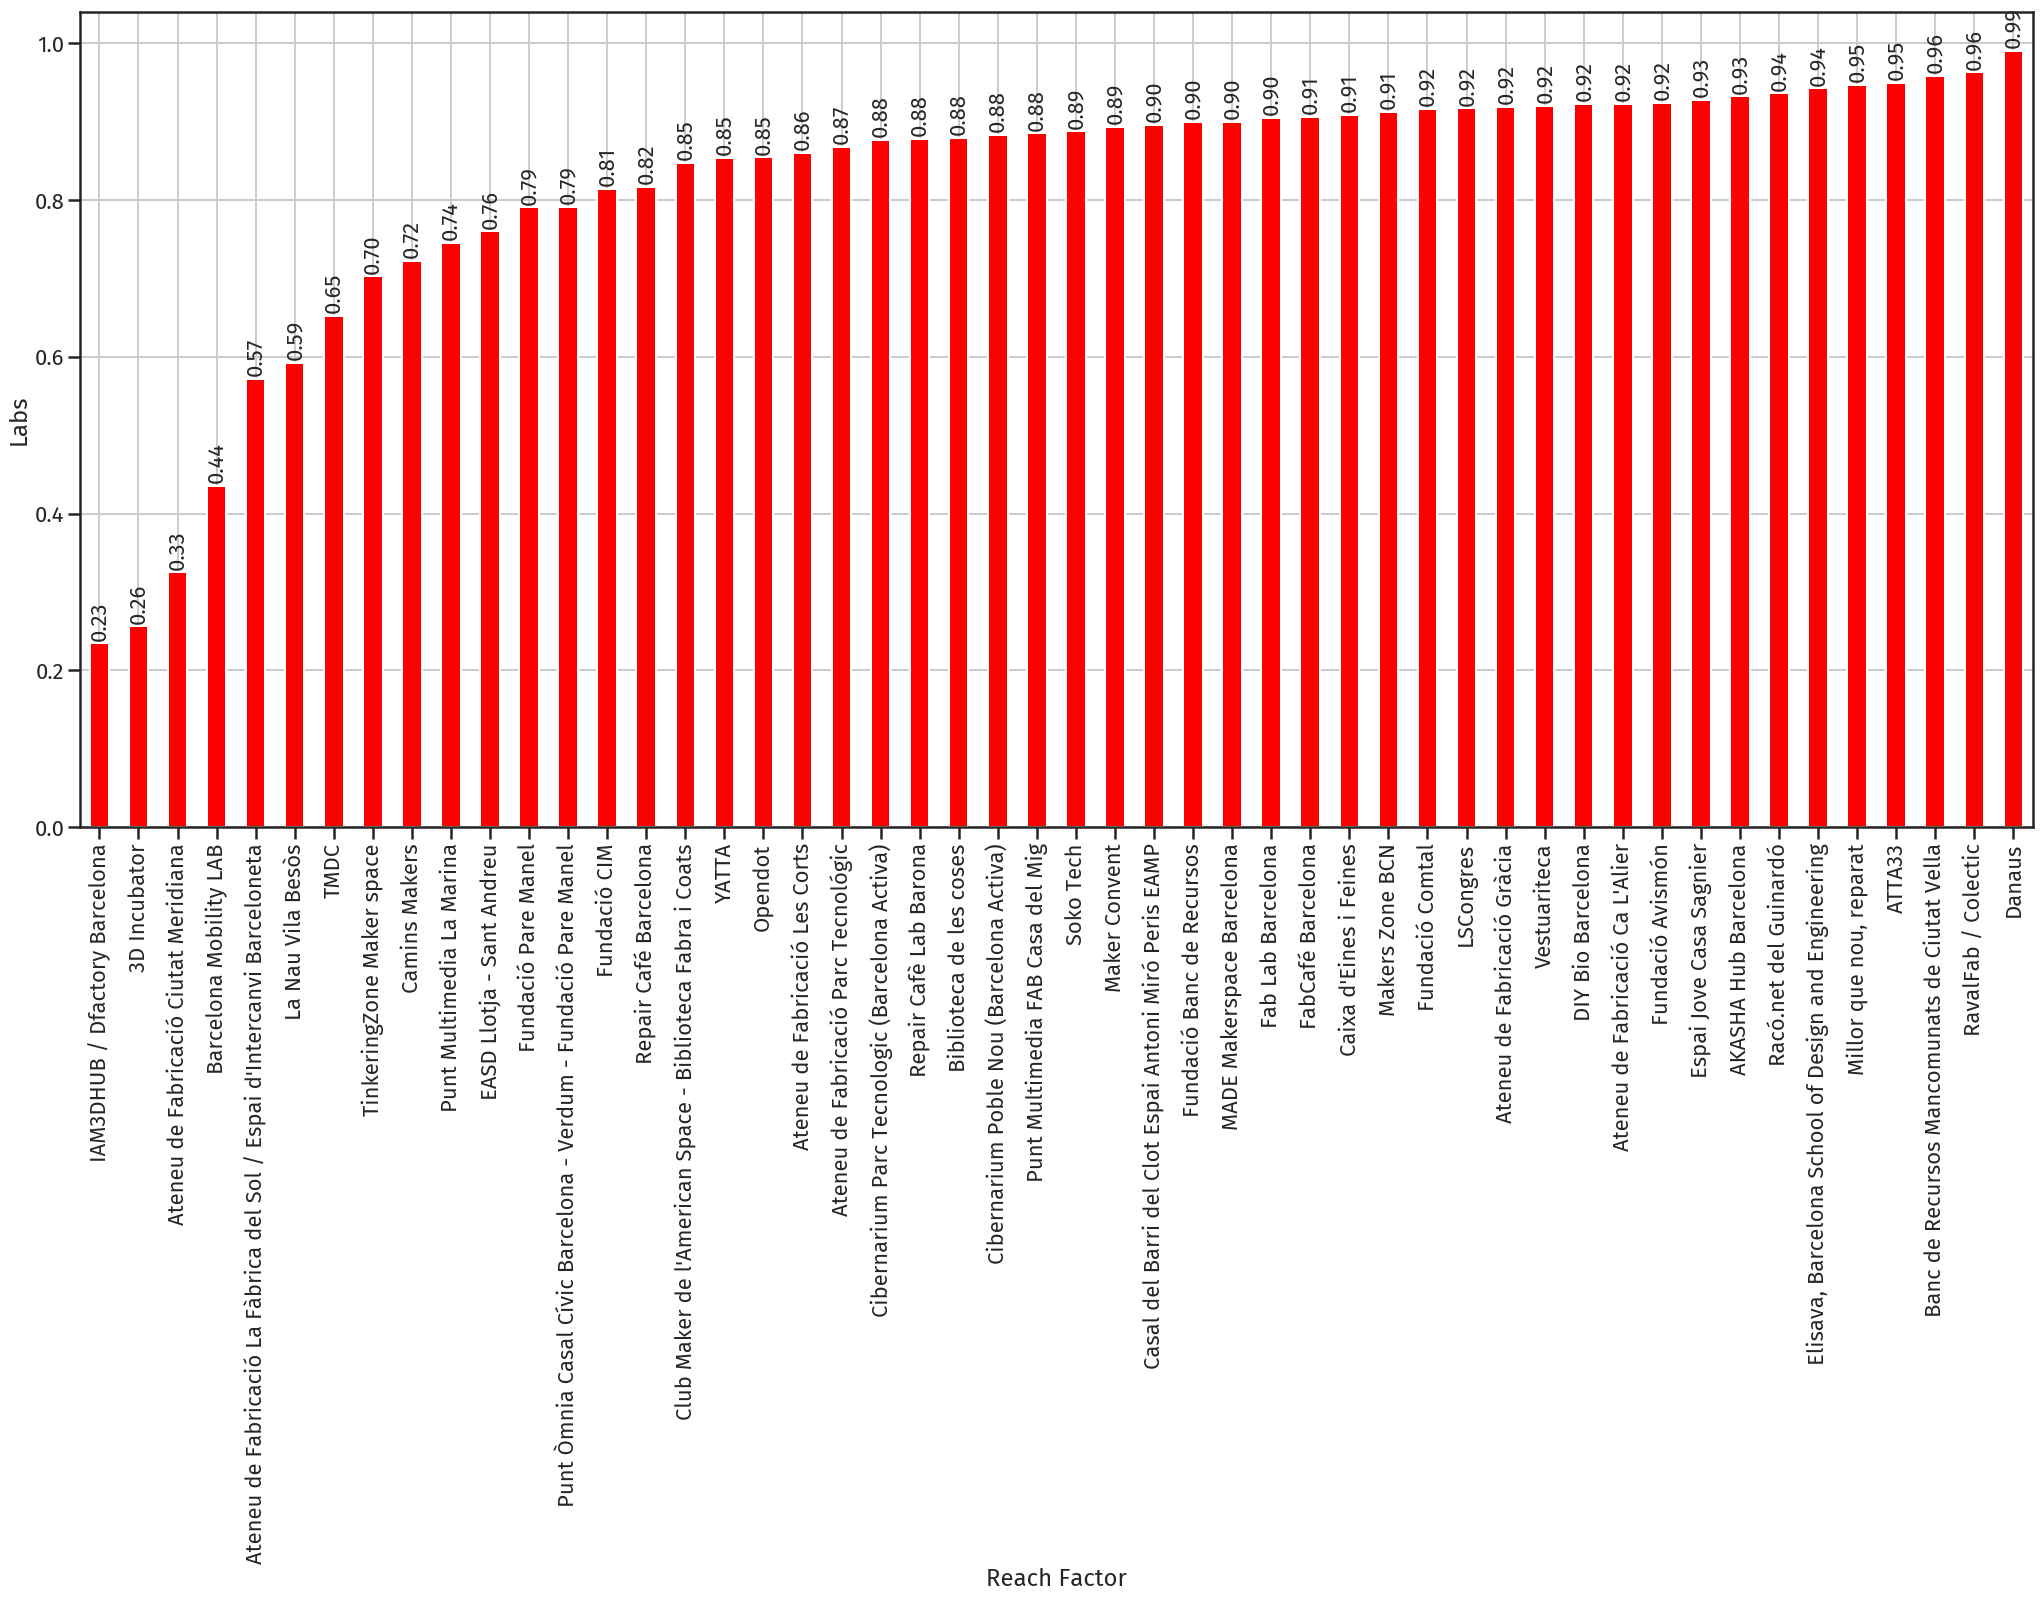

In [31]:
ax = map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_bar_vertical.png", dpi=300, bbox_inches="tight")

### Labs values clustered by city

In [32]:
full_map_data.groupby(["Cluster","Type"]).size()

Cluster  Type                                                                   
BCN      Ateneu de Fabricació                                                       5
         Ateneu de Fabricació / Barcelona Recircula – Tool Library / Repair Cafè    1
         Barcelona Recircula – Tool Library / Repair Cafè                           7
         City Space                                                                 5
         DIYBio Lab                                                                 1
         Fab Lab                                                                    6
         FabCafé                                                                    1
         Foundation                                                                 3
         Hackerspace                                                                2
         Incubator-Accelerator                                                      4
         Library                                           

In [33]:
full_map_data.groupby("Cluster")["total_pop"].sum()

Cluster
BCN    3703884.0
MI      177920.0
Name: total_pop, dtype: float64

In [34]:
full_map_data.groupby("Cluster")["total_pop"].describe()

count          mean           std      min       25%      50%  \
Cluster                                                                  
BCN       46.0  80519.217391  20737.864010  11587.0  76958.50  87927.5   
MI         4.0  44480.000000   9548.455617  31641.0  41526.75  45823.5   

              75%       max  
Cluster                      
BCN      93906.75  101992.0  
MI       48776.75   54632.0

In [35]:
full_map_data.groupby("Cluster")["area"].sum()

Cluster
BCN    1.849892e+08
MI     1.613665e+07
Name: area, dtype: float64

In [36]:
full_map_data.groupby("Cluster")["area"].describe()

count          mean            std         min           25%  \
Cluster                                                                 
BCN       46.0  4.021505e+06  901207.277315  1150407.81  3.910294e+06   
MI         4.0  4.034164e+06  394467.411026  3448109.56  4.003705e+06   

                50%           75%         max  
Cluster                                        
BCN      4389960.44  4.522935e+06  4859209.70  
MI       4191091.59  4.221551e+06  4306361.89

In [37]:
full_map_data.groupby("Cluster")["reachfactor"].describe()

count      mean       std     min       25%      50%       75%  \
Cluster                                                                   
BCN       46.0  0.819263  0.183582  0.2344  0.796625  0.89435  0.921400   
MI         4.0  0.821825  0.080384  0.7024  0.815650  0.85380  0.859975   

            max  
Cluster          
BCN      0.9899  
MI       0.8773

plot the data

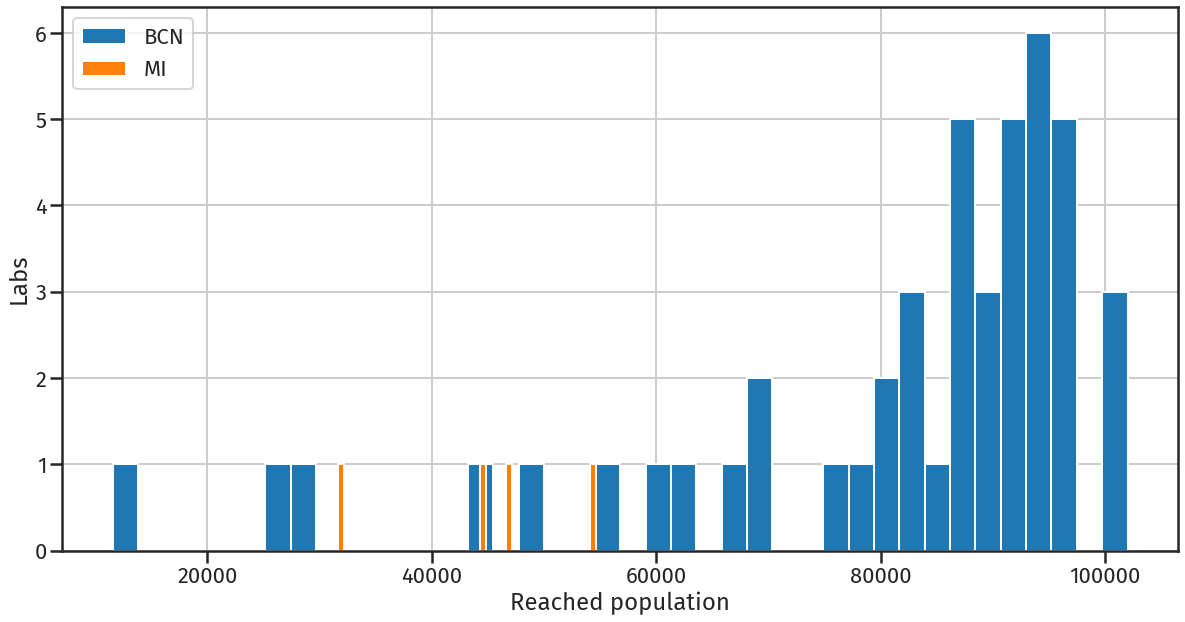

In [38]:
full_map_data.groupby("Cluster")["total_pop"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data for each lab

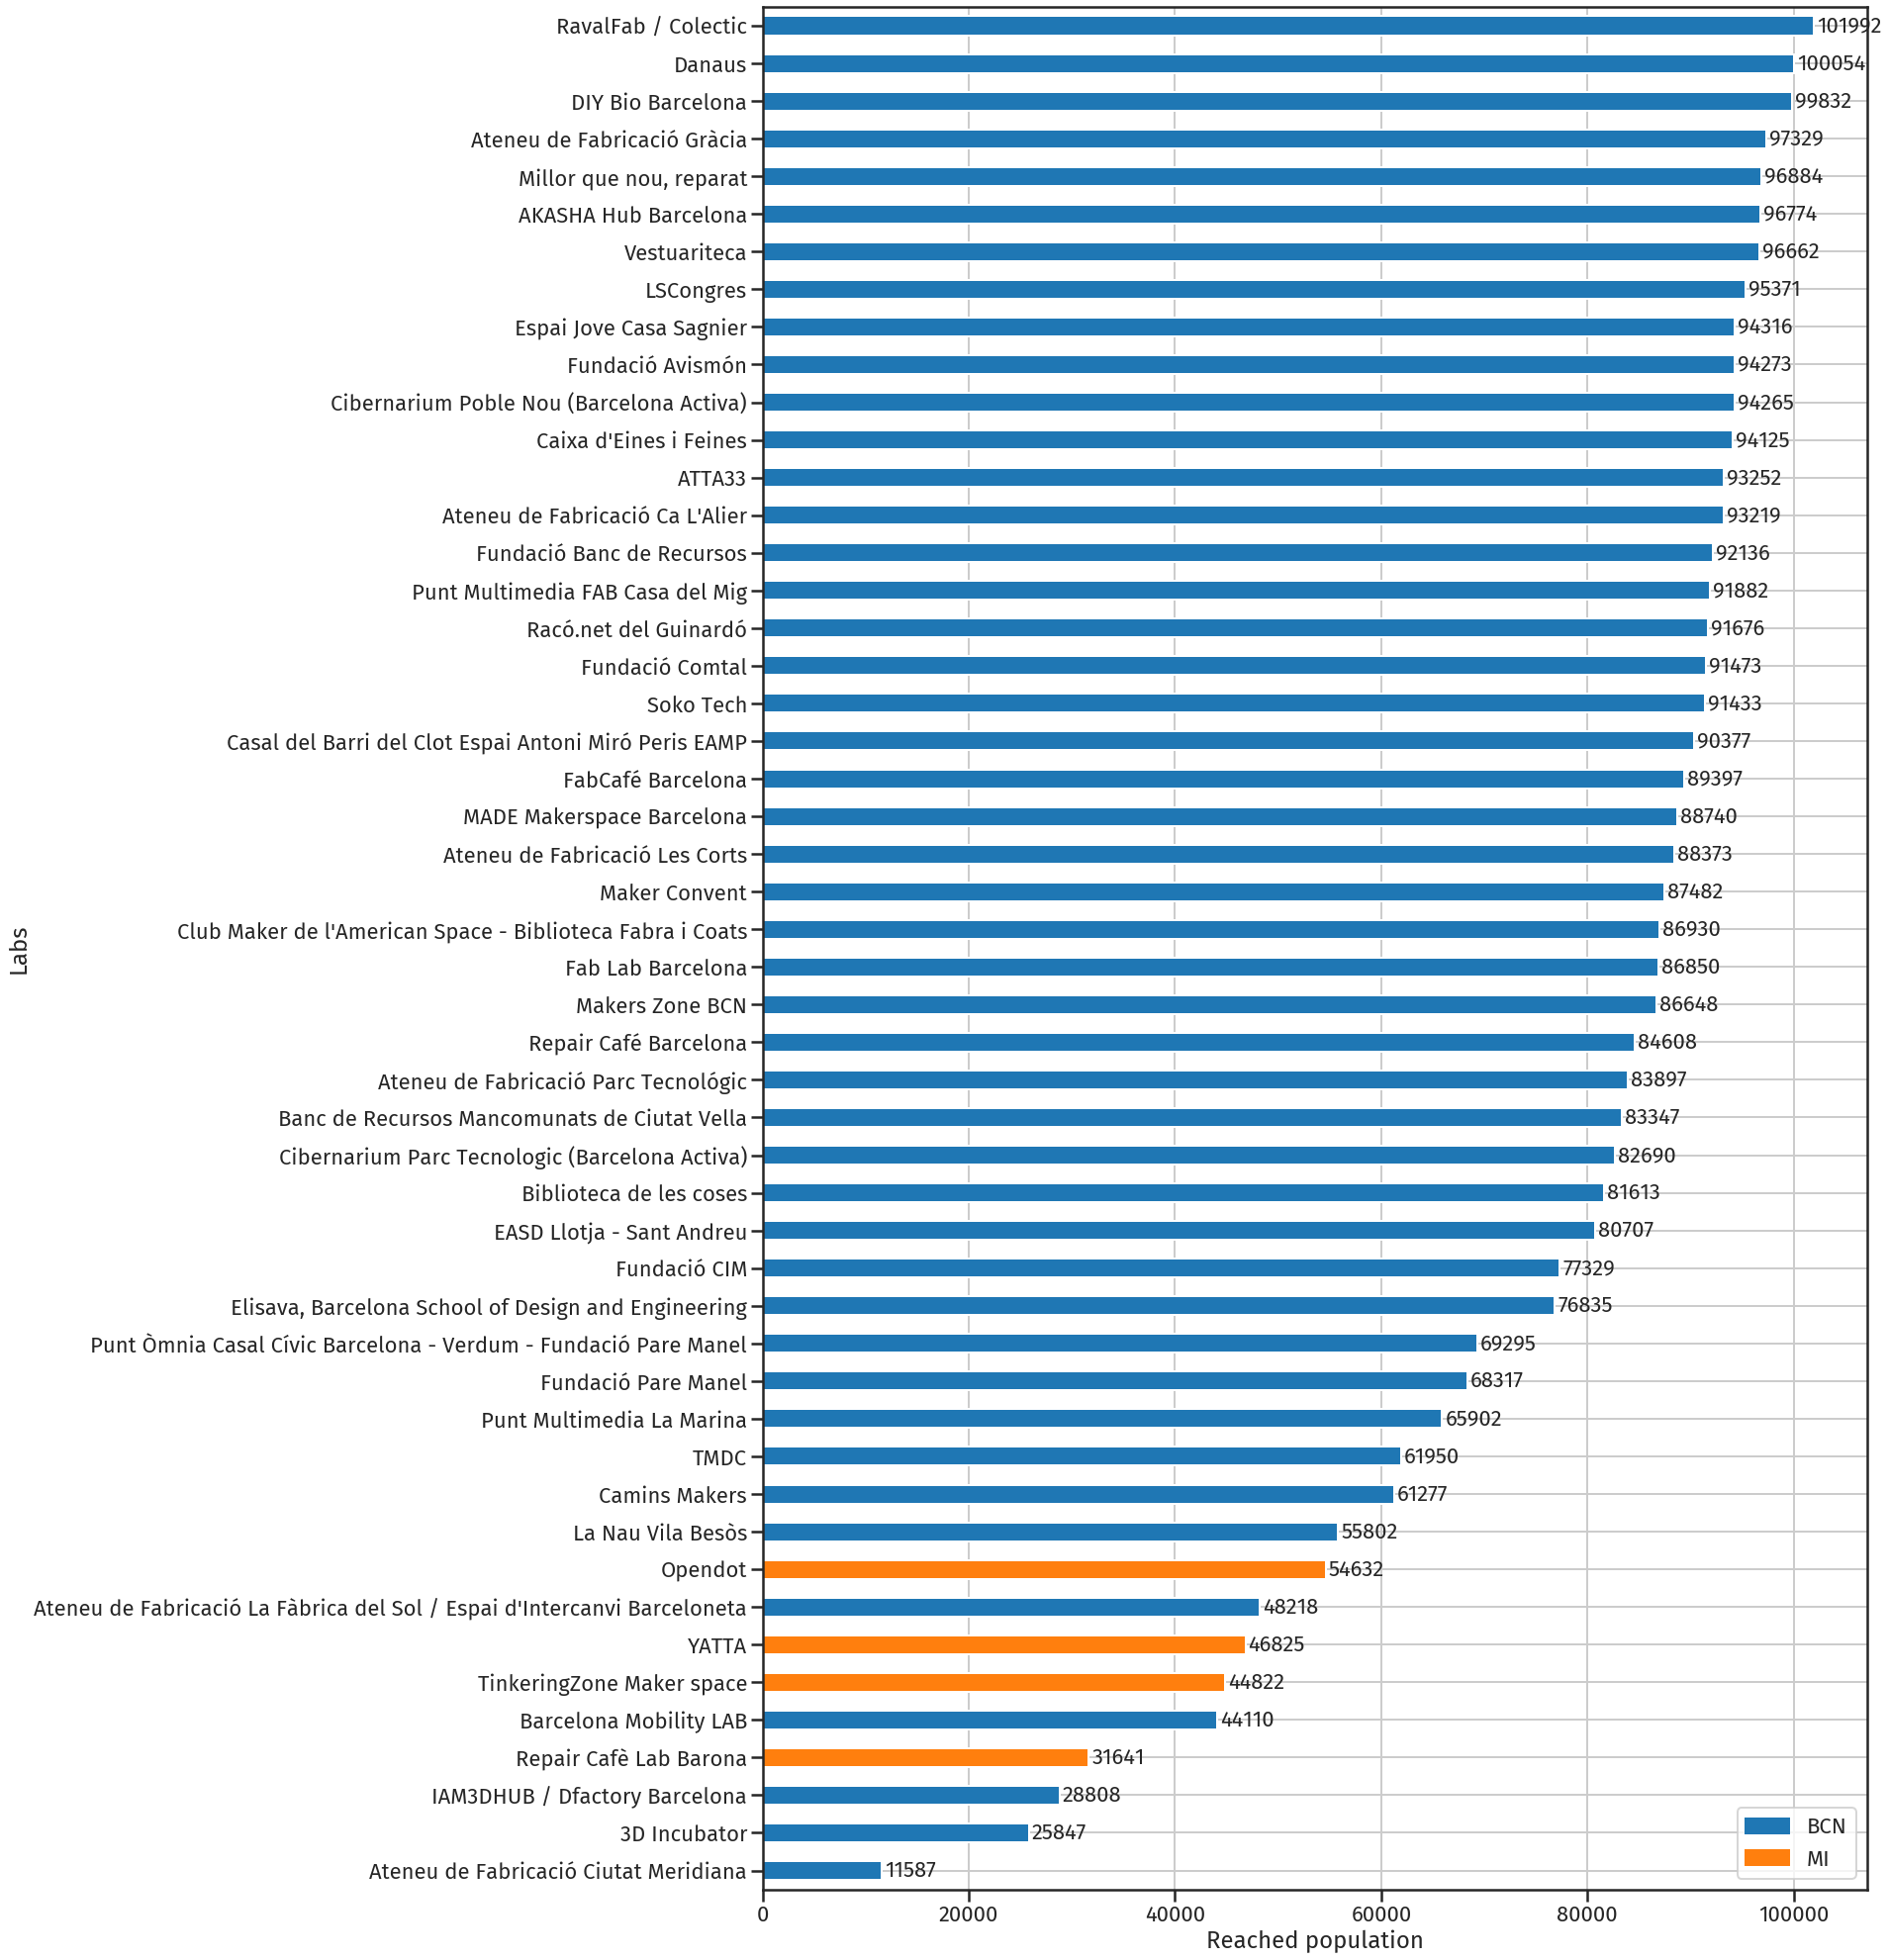

In [39]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['total_pop'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_bar.png", dpi=300, bbox_inches="tight")

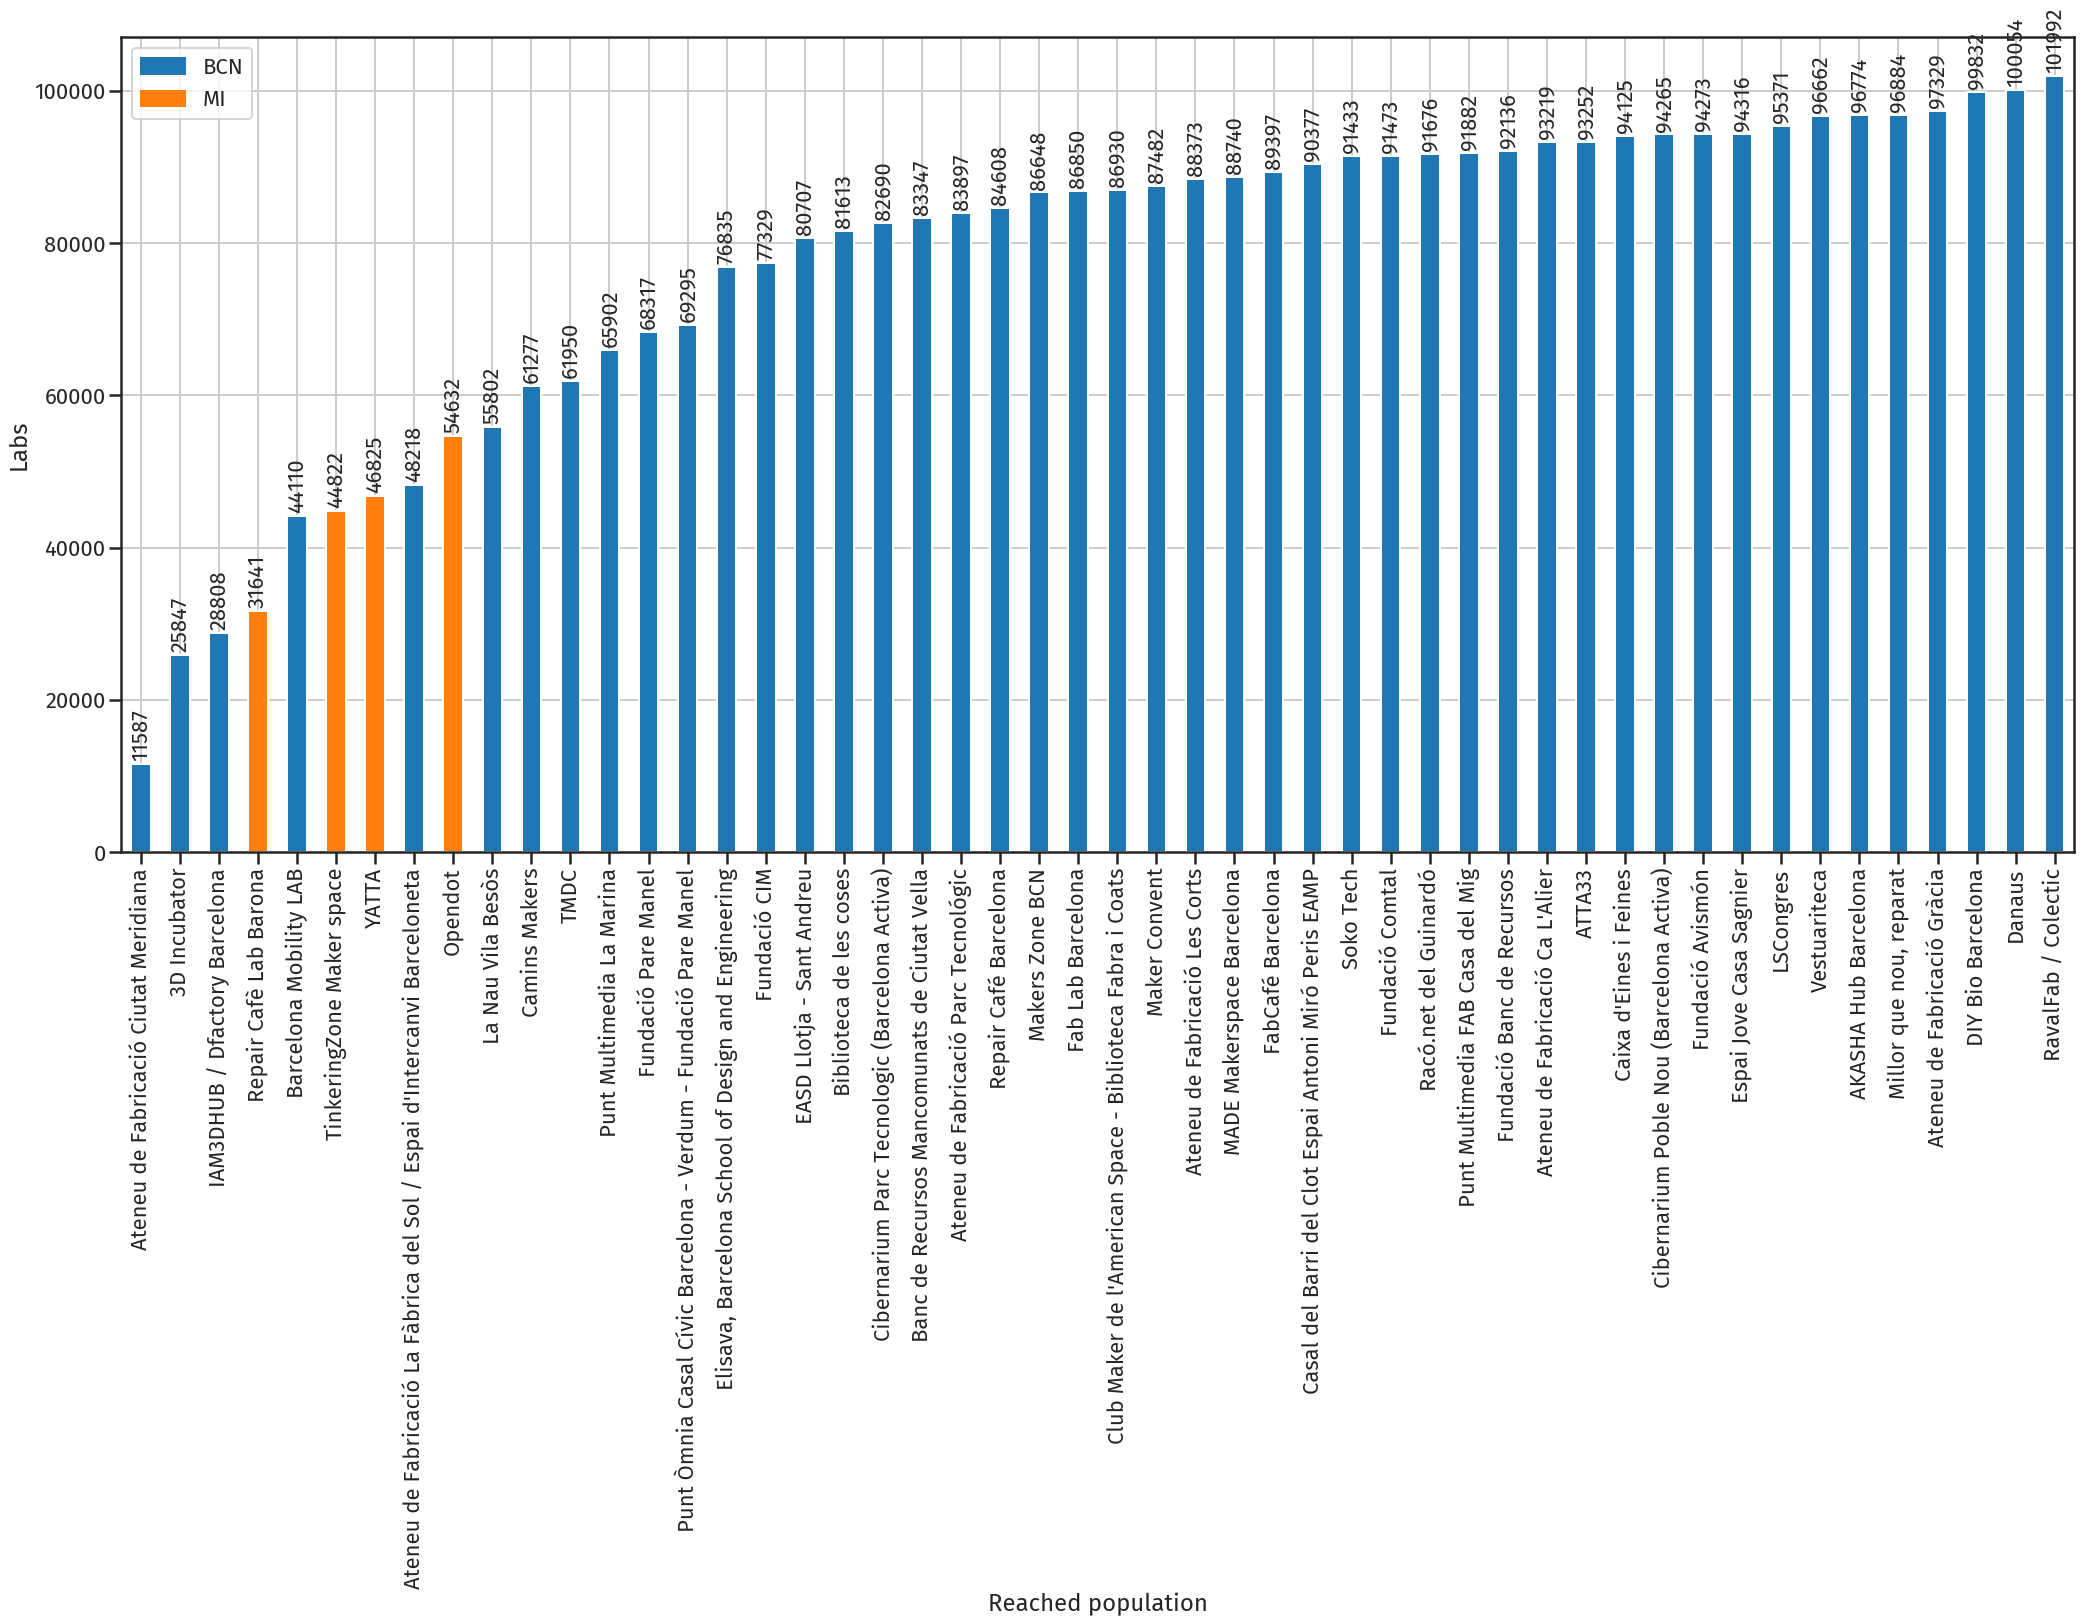

In [40]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['total_pop'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

plot the data

In [41]:
full_map_data["area"] = full_map_data["area"].divide(1000000)

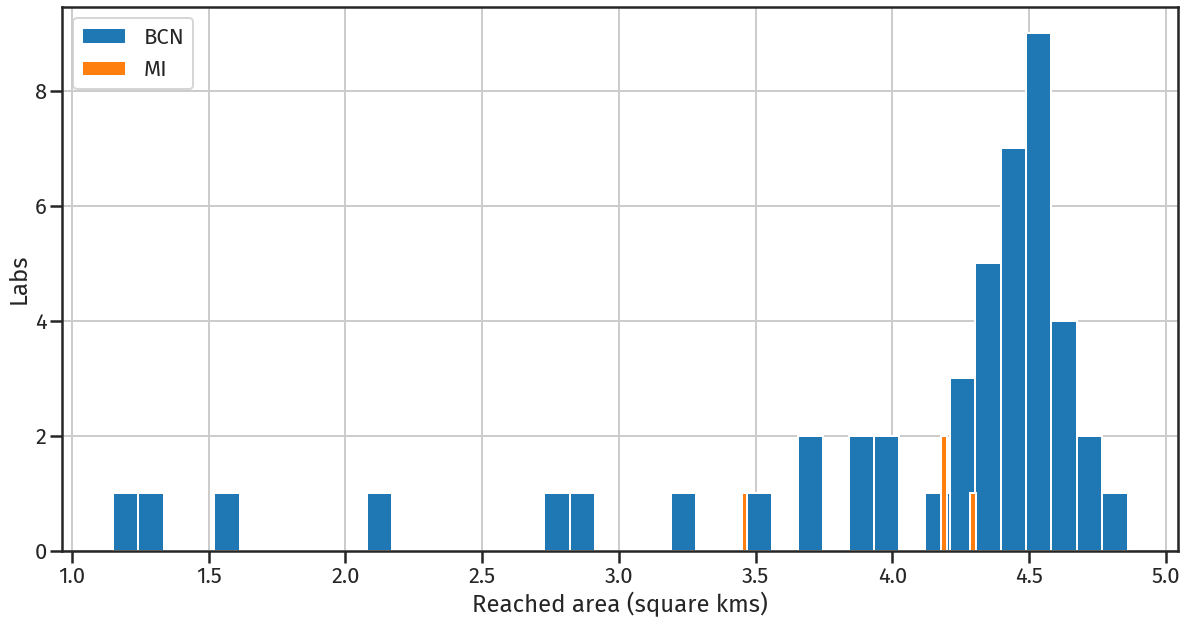

In [42]:
full_map_data.groupby("Cluster")["area"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data 

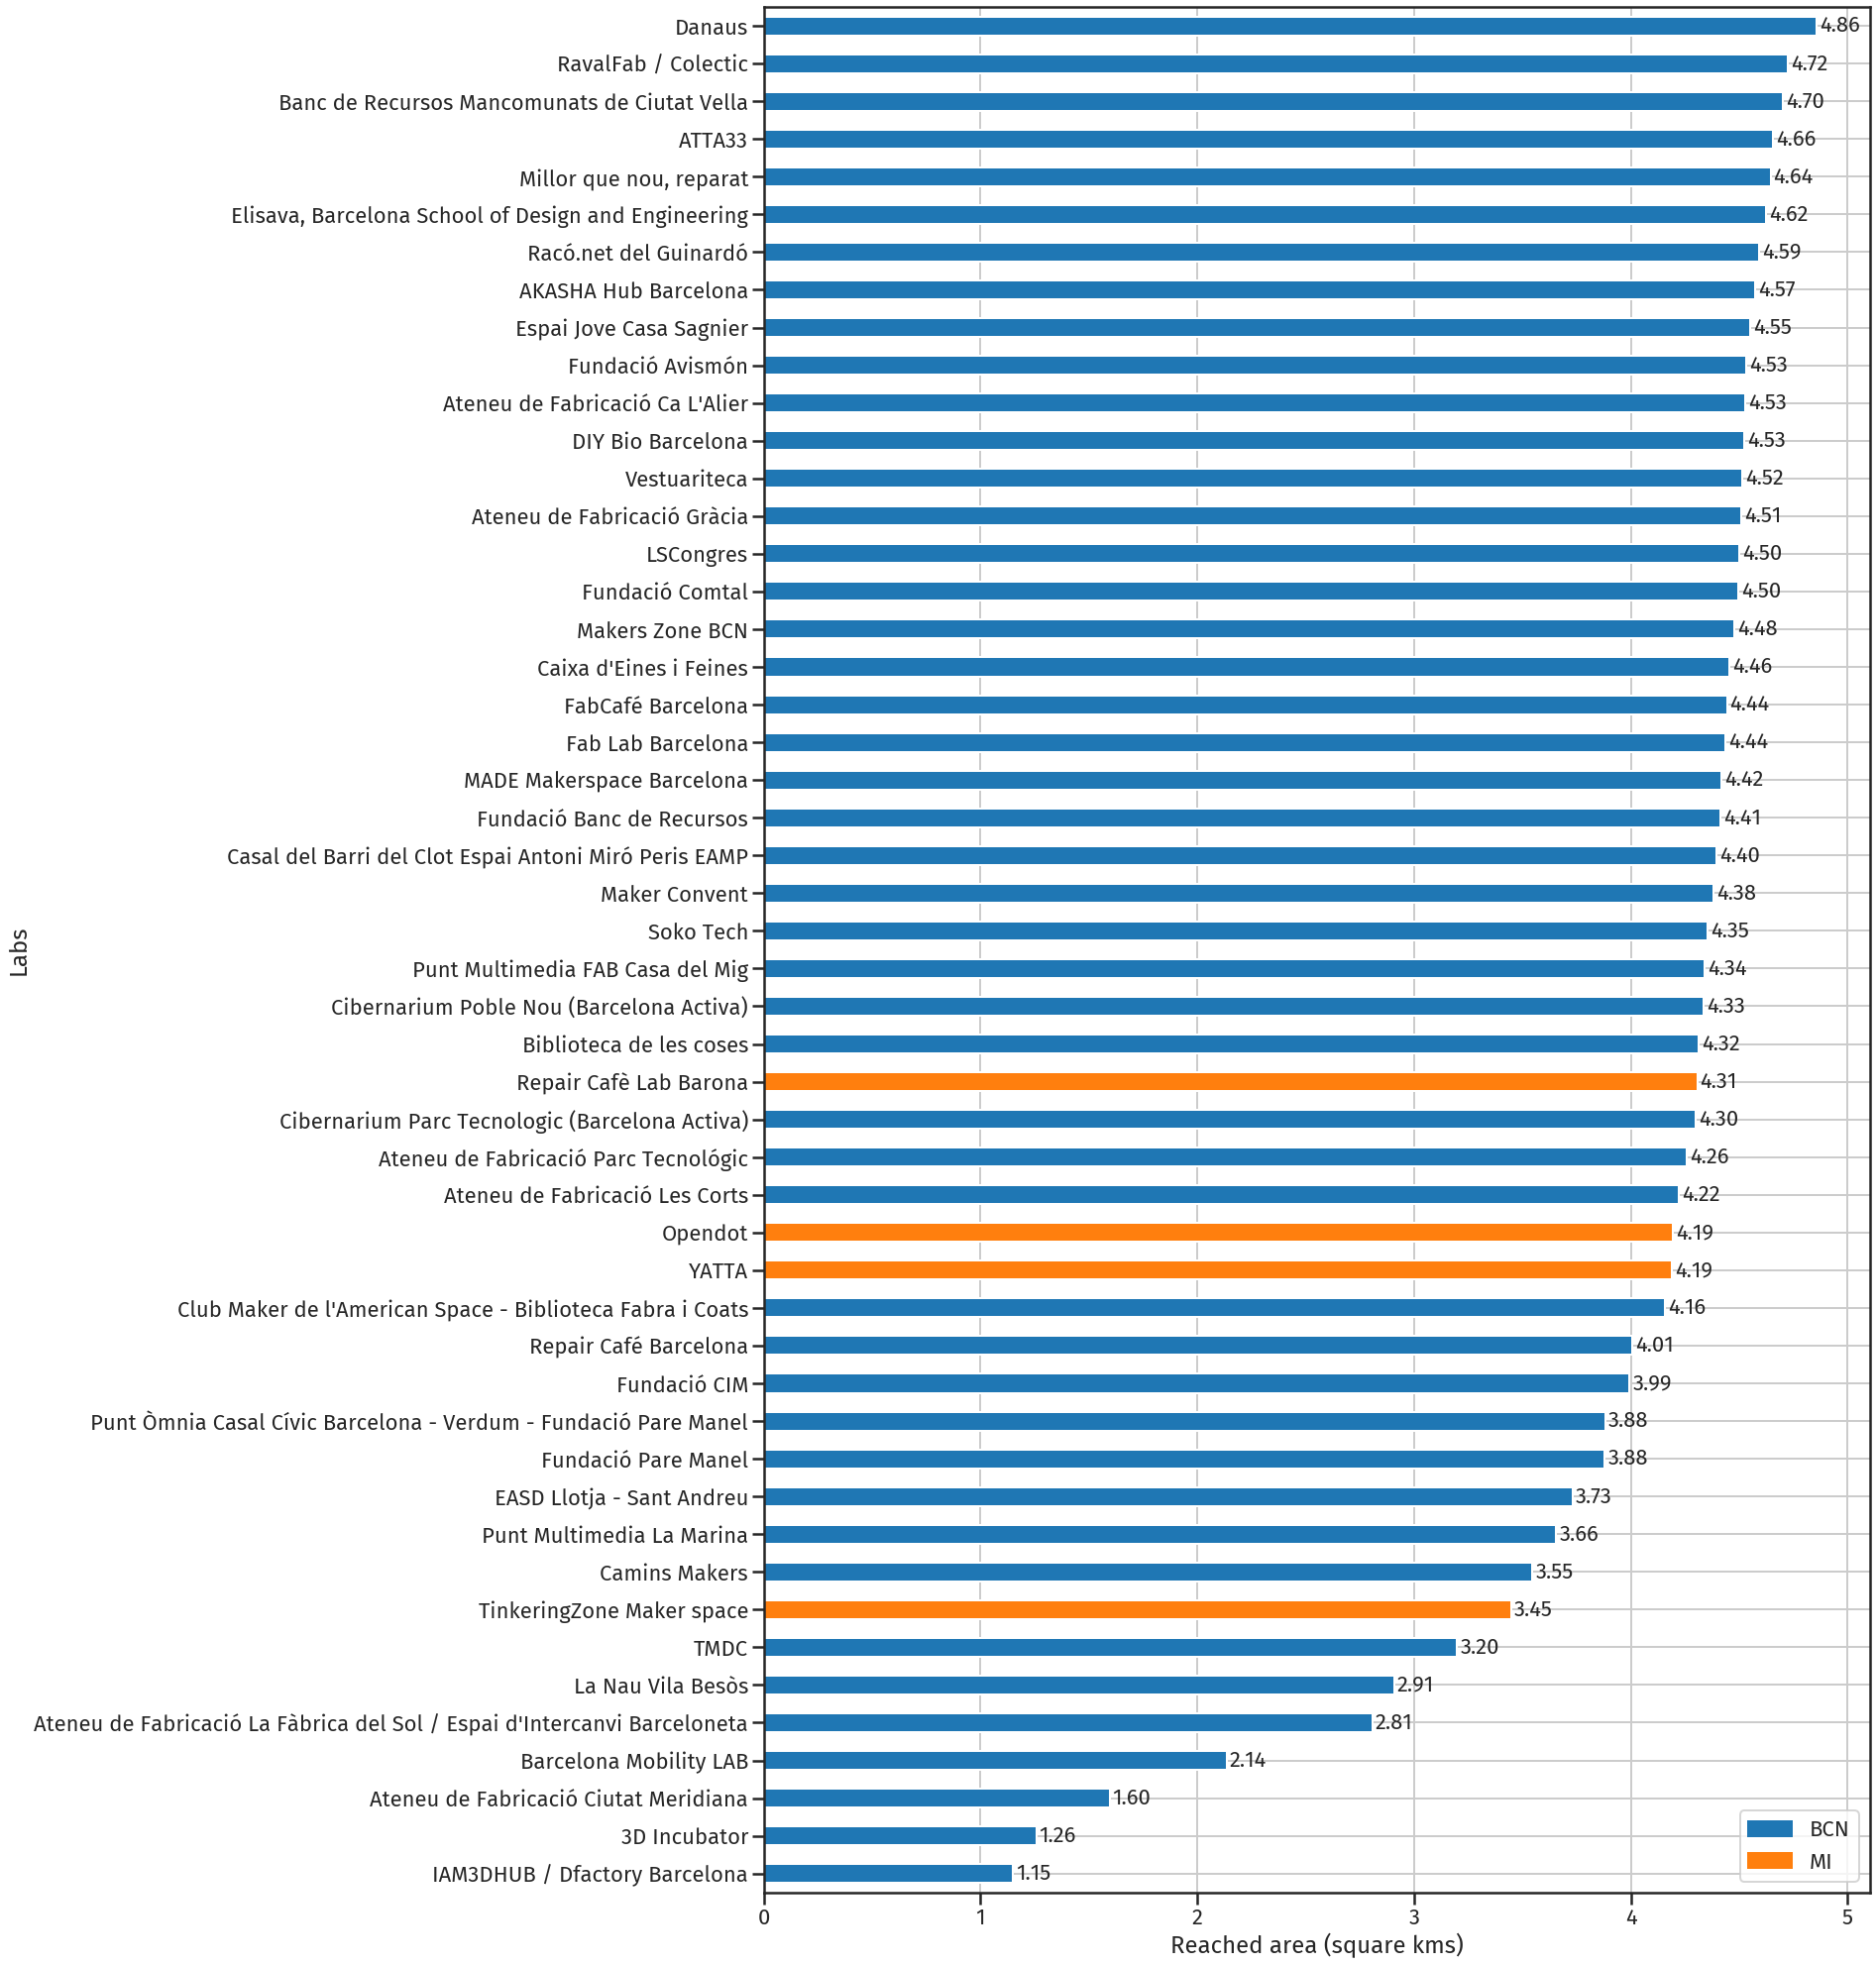

In [43]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['area'])['area'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['area'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_bar.png", dpi=300, bbox_inches="tight")

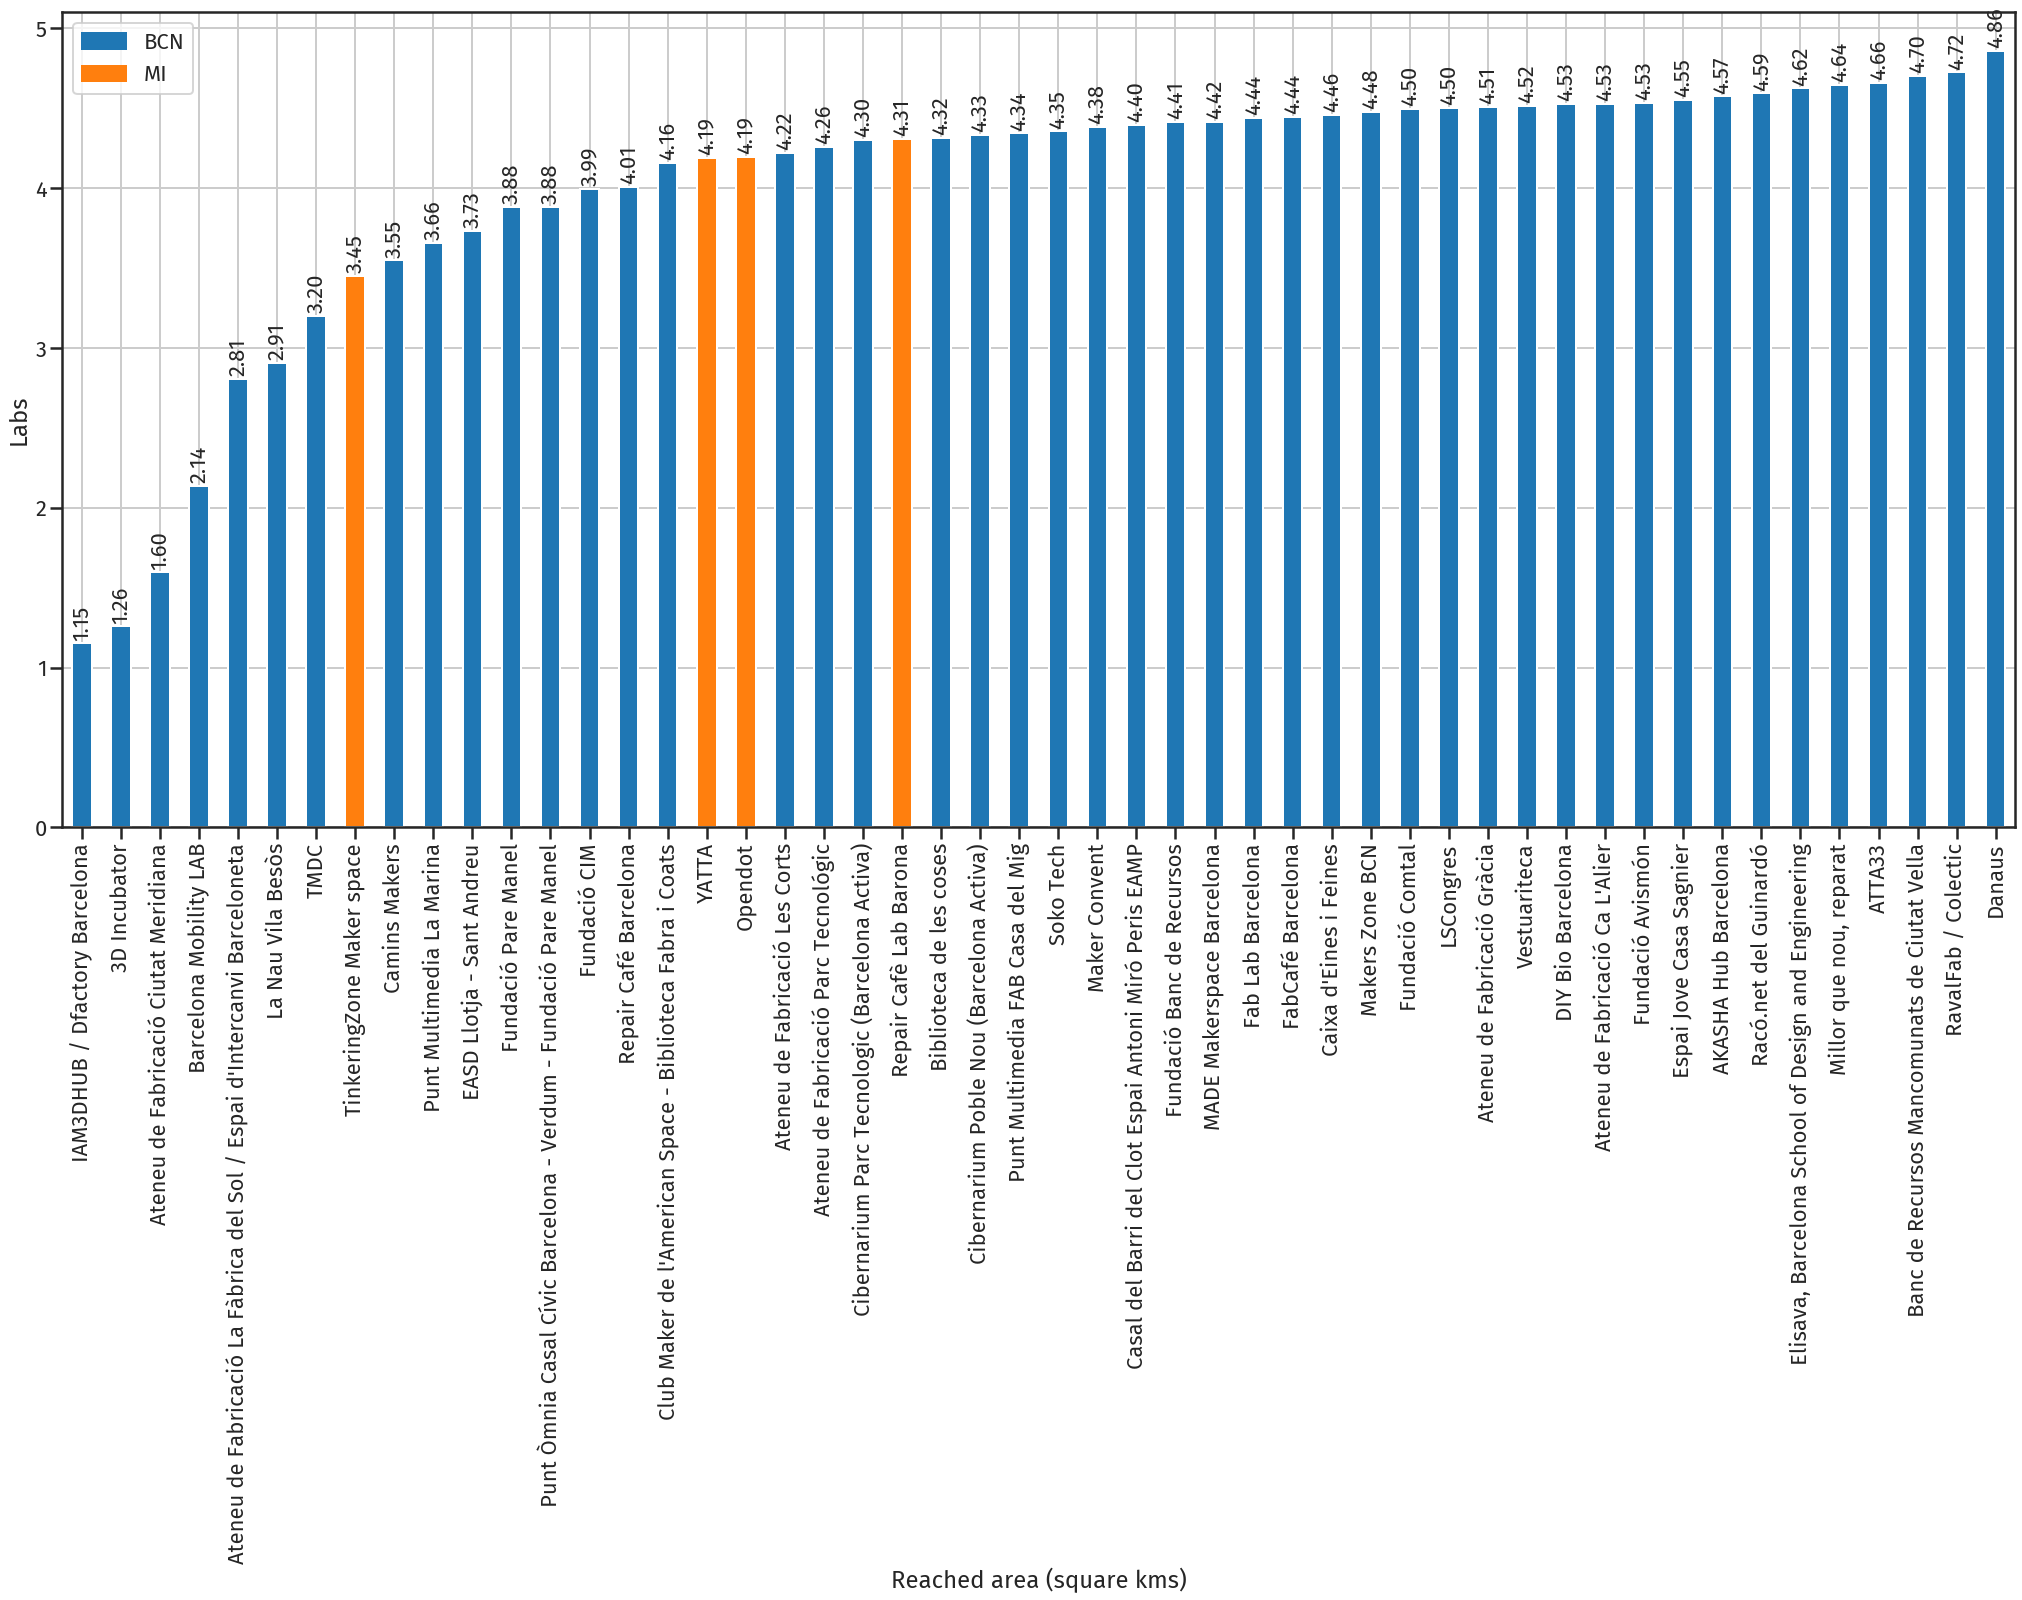

In [44]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['area'])['area'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['area'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

plot the data

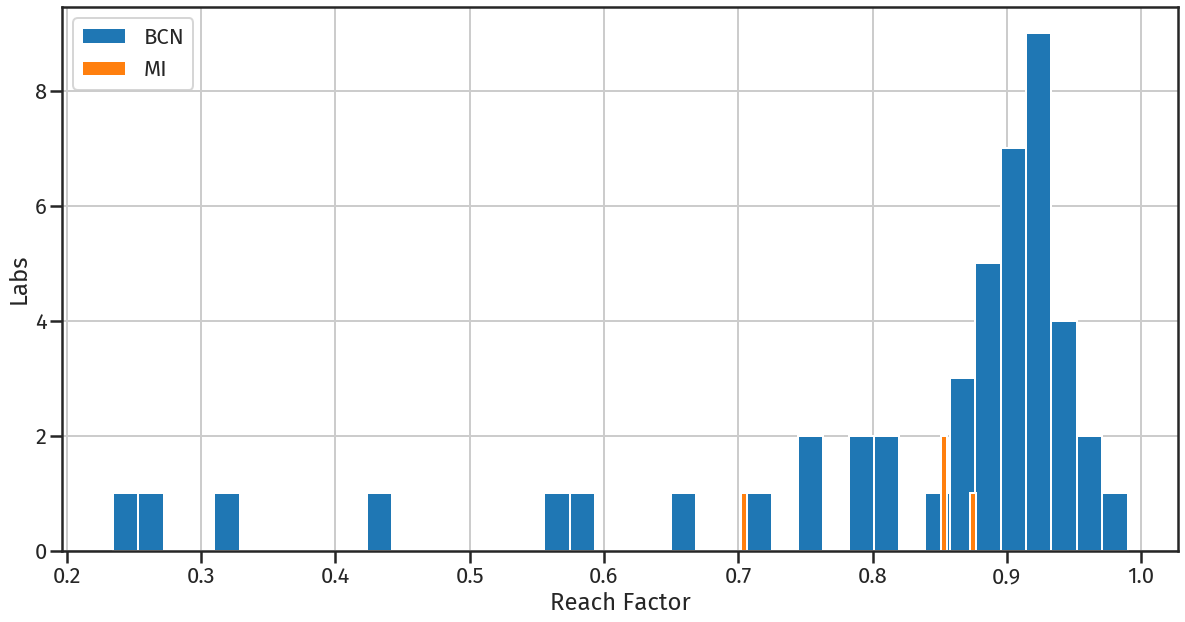

In [45]:
full_map_data.groupby("Cluster")["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data

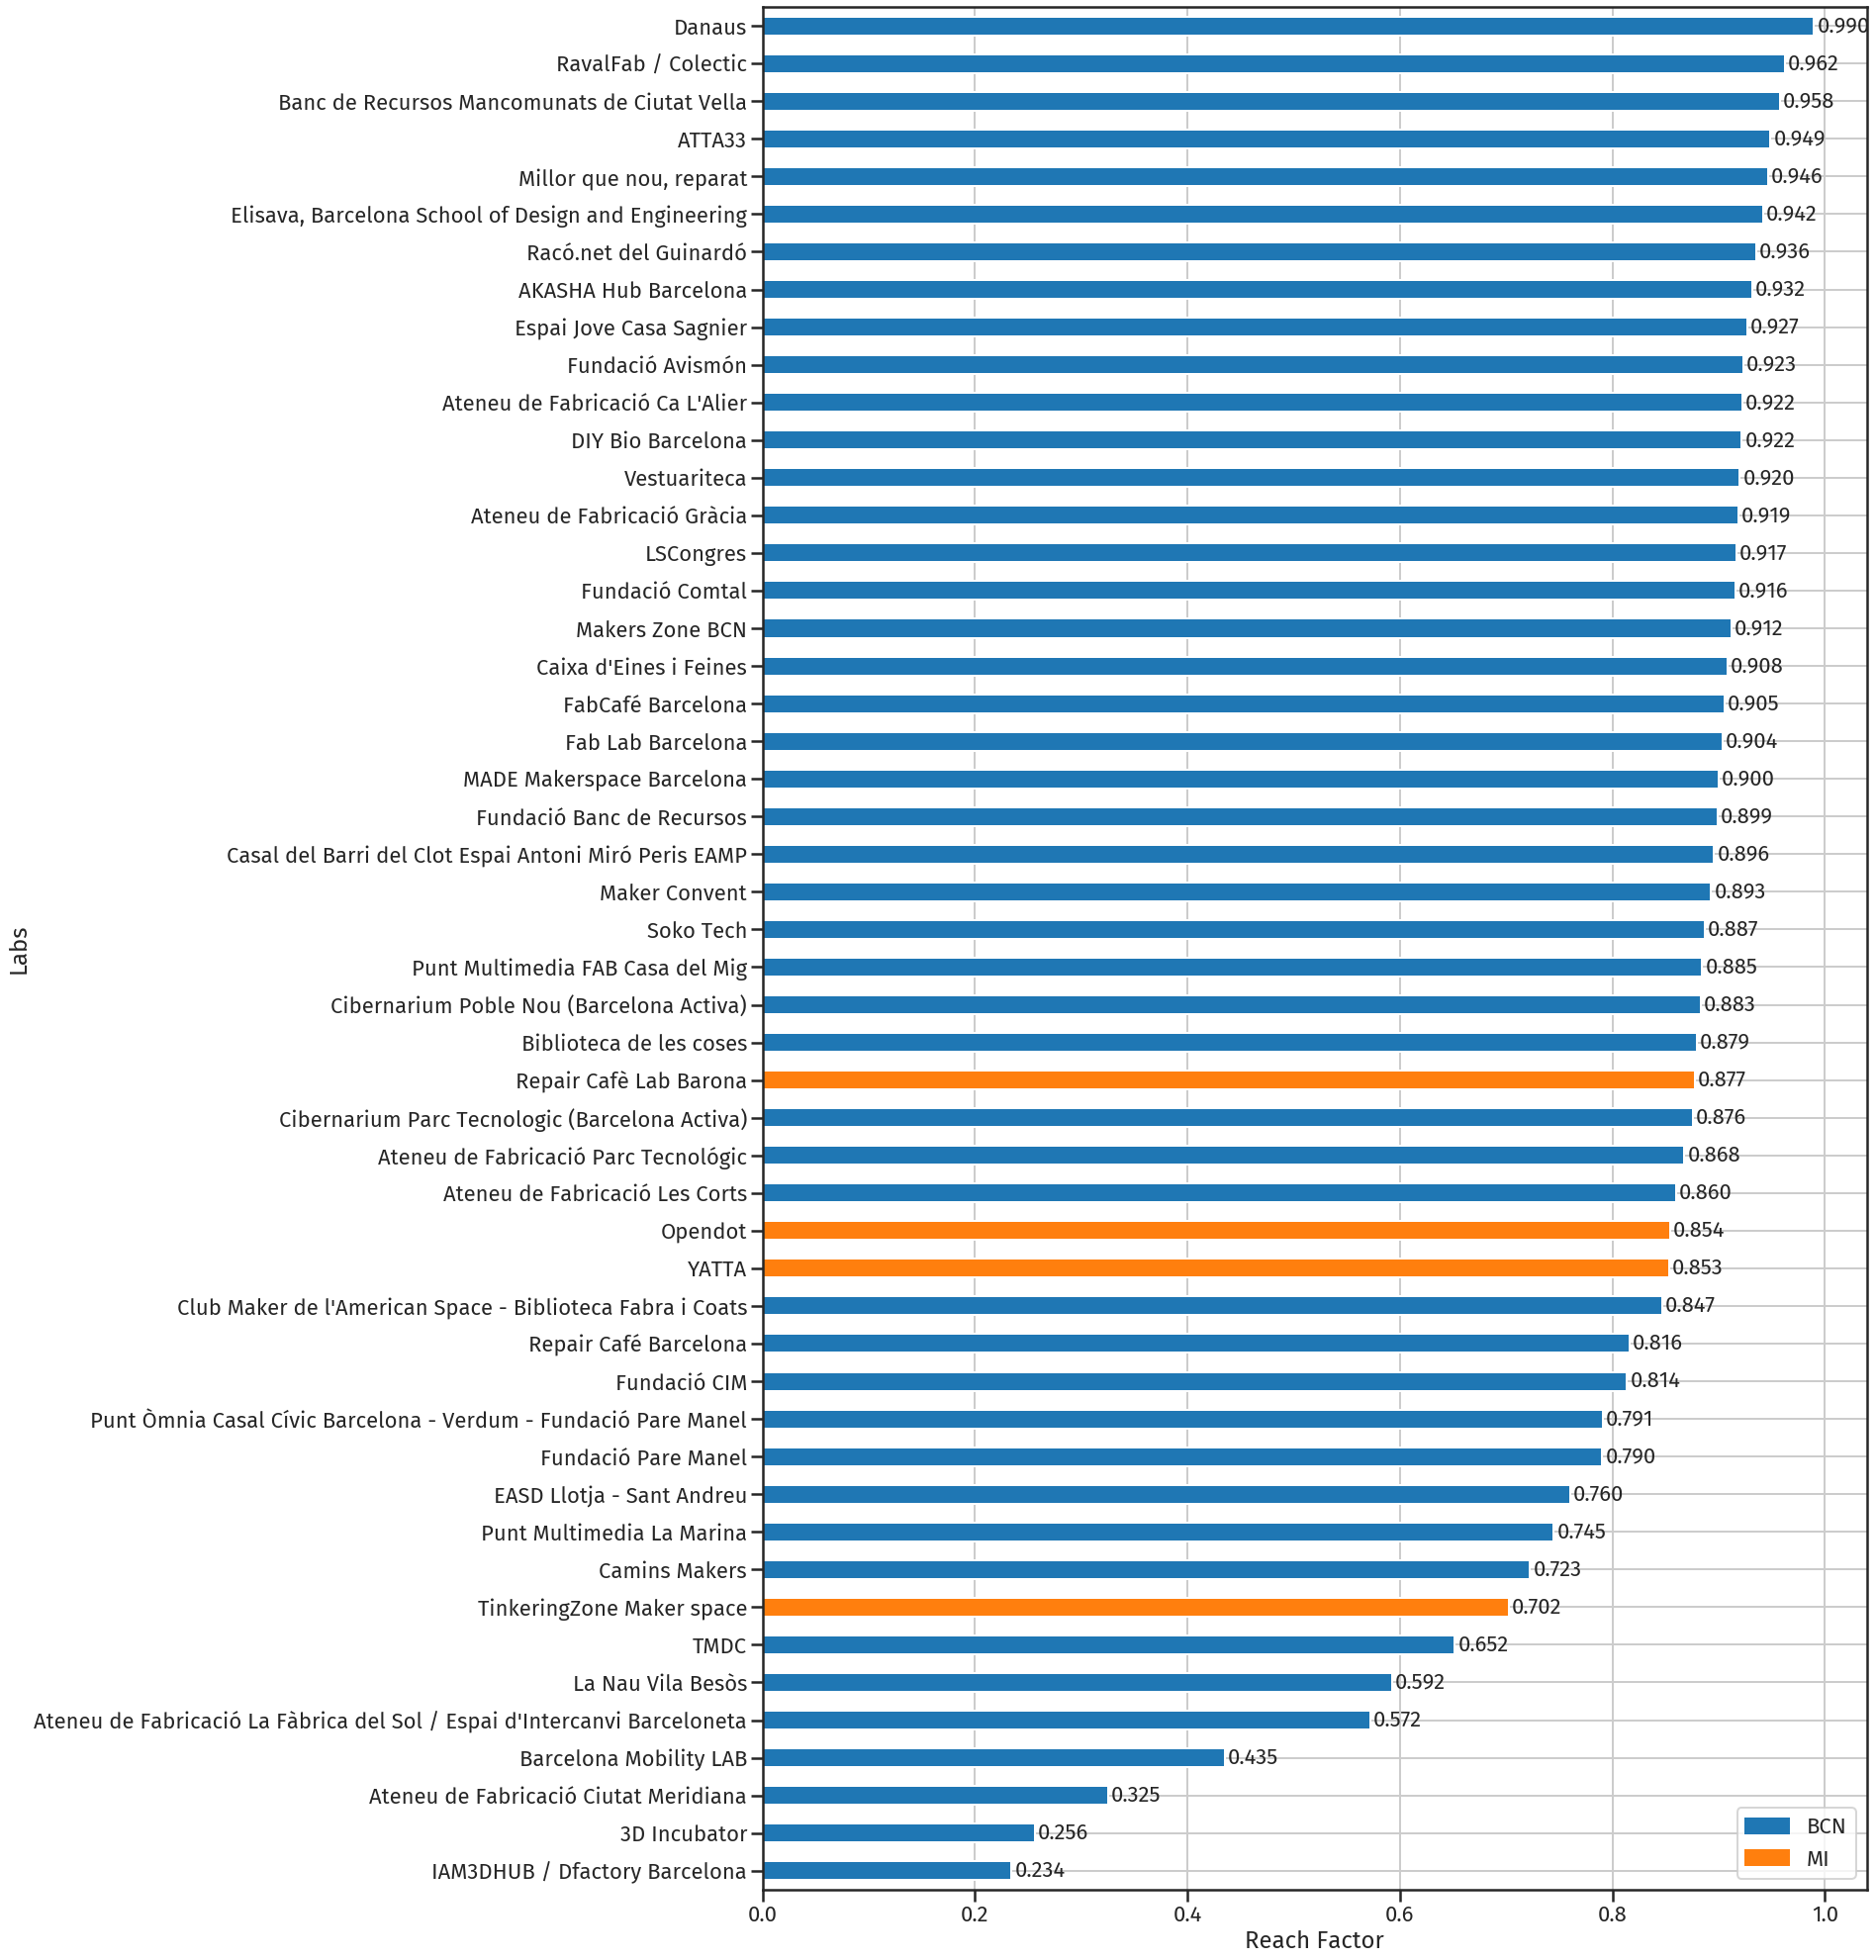

In [46]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['reachfactor'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.3f", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_bar.png", dpi=300, bbox_inches="tight")

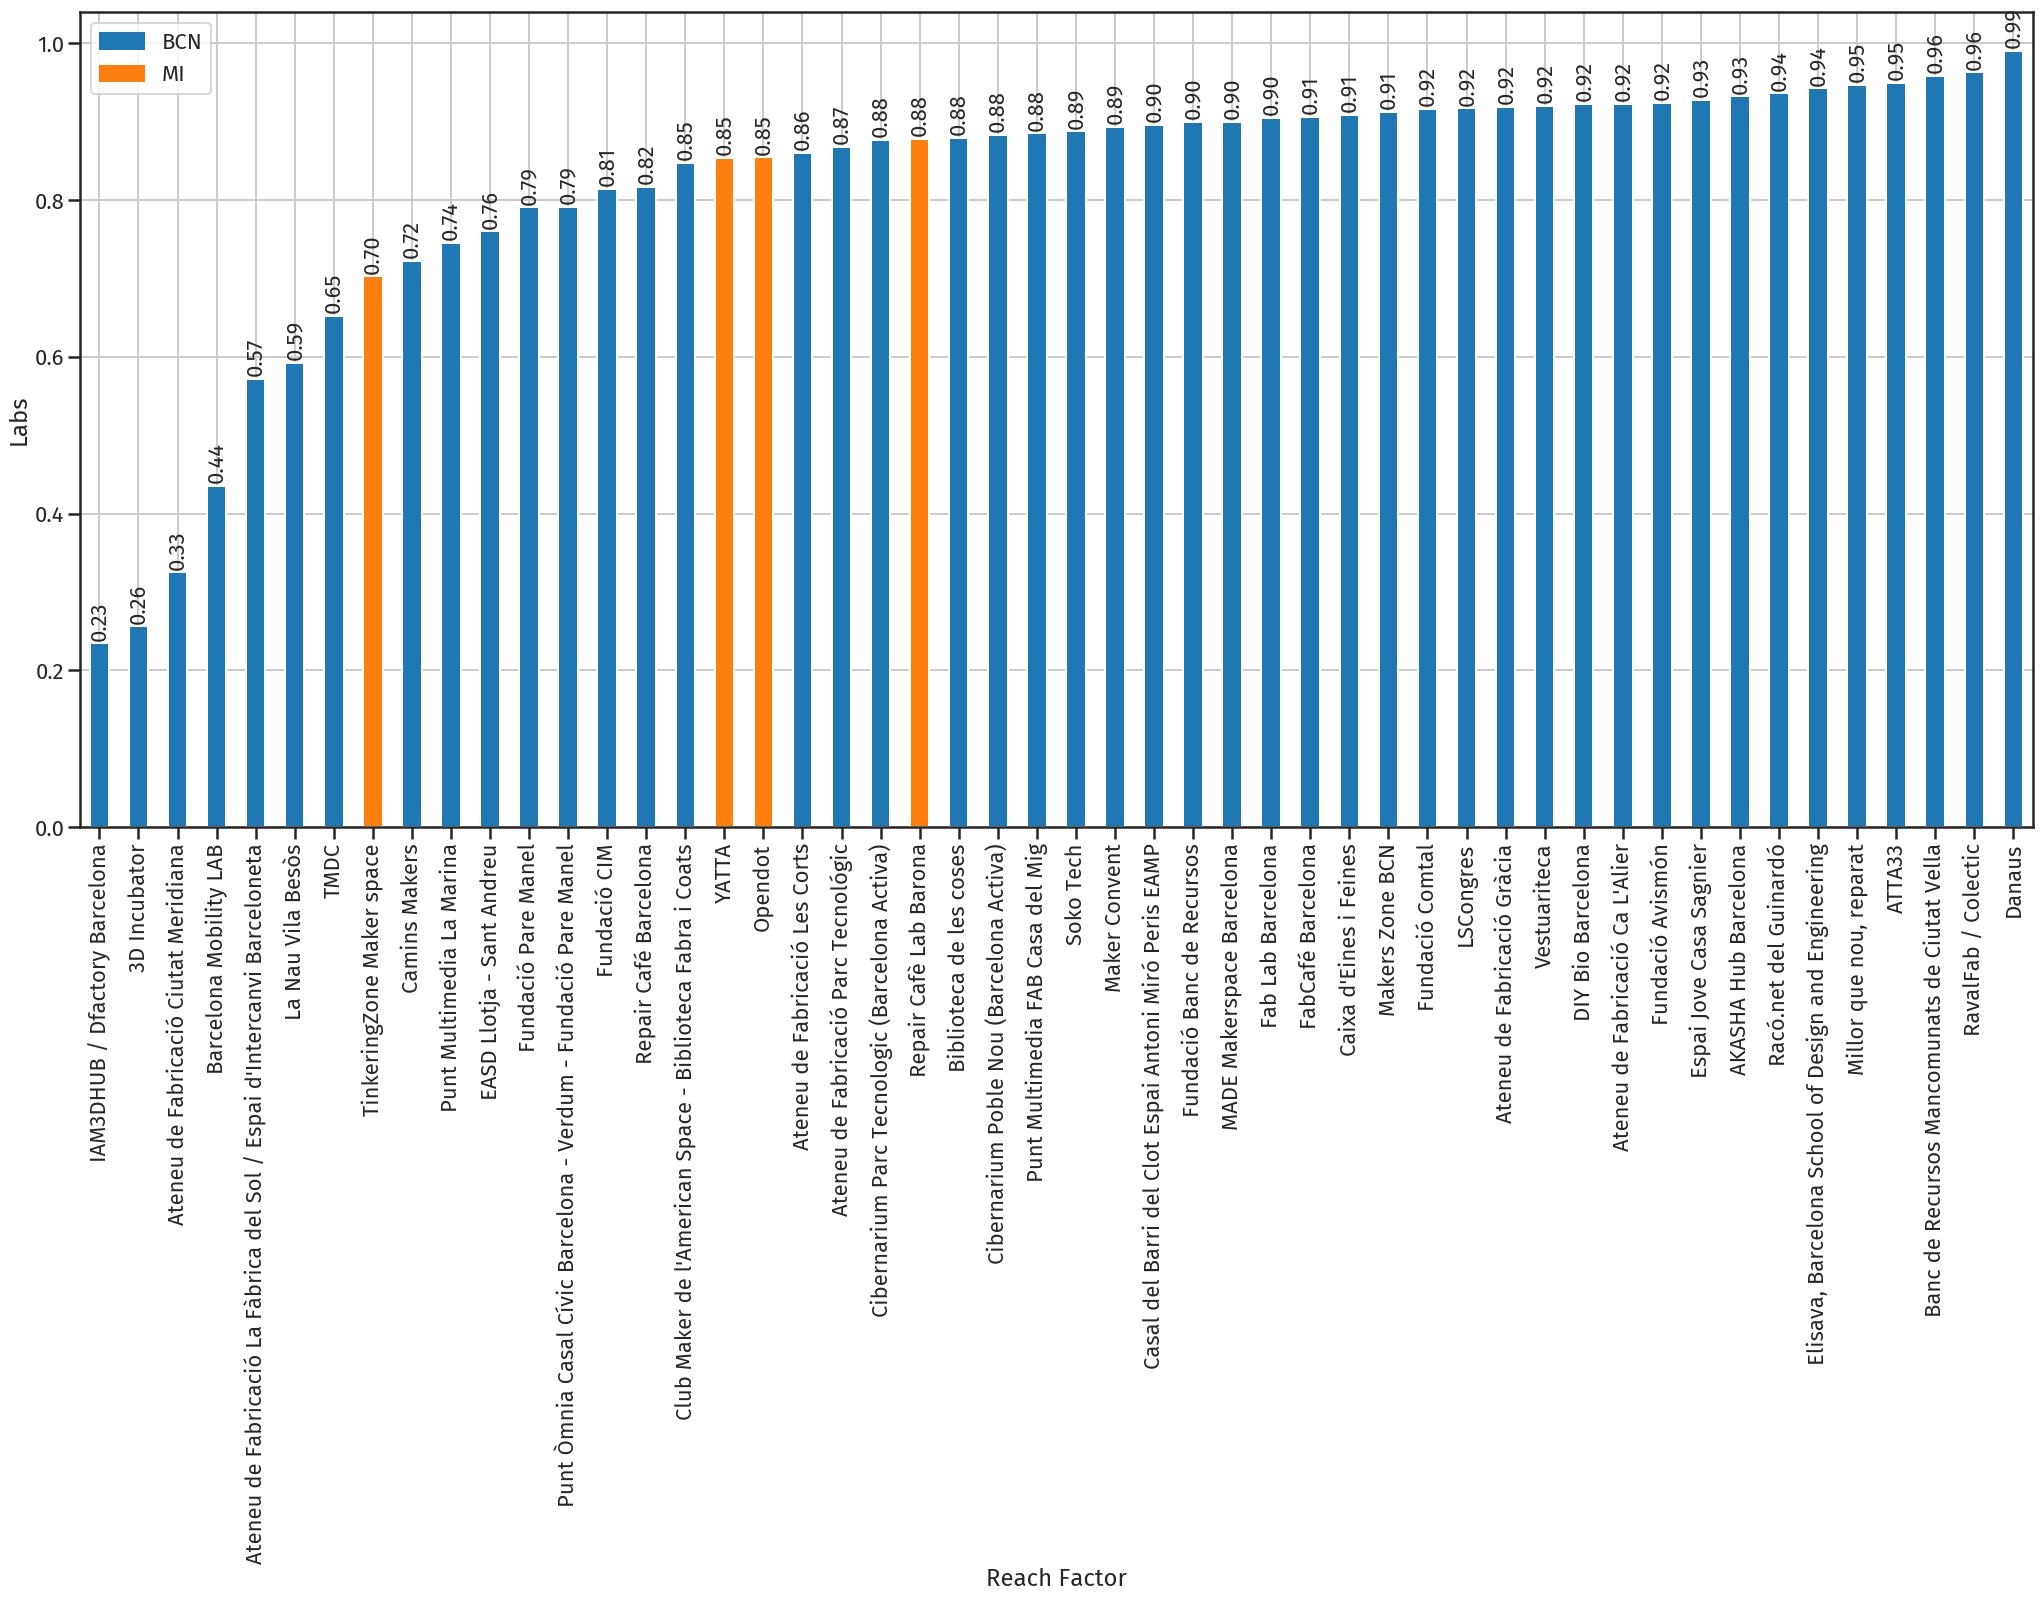

In [47]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['reachfactor'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

### Isochrones

create the map

In [48]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

In [49]:
for iso in data:
  folium.GeoJson(iso, name="geojson").add_to(m)
for loc in locations:
  #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
  folium.Circle(
    radius=30,
    location=[locations[loc][1],locations[loc][0]],
    popup=loc,
    tooltip=loc,
    color="crimson",
    fill="crimson",
).add_to(m)


show the map

red points = labs<Br/>
blu lines = isocrones 15' for each lab as center

In [50]:
folium.LayerControl().add_to(m)
m

save the web map

In [51]:
m.save("html" + os.sep + "city_isochrones.html")

### Isochrones with color from population reached

create the legend with a graduated color scale (yellow less, blu more)

In [52]:
linear = cmp.LinearColormap(
    ['yellow', 'green', 'blue'],
    vmin=map_data['total_pop'].min(), vmax=map_data['total_pop'].max(),
    caption='Total population'
)
linear

In [53]:
sns.color_palette(cc.glasbey_light, len(full_map_data.groupby(['Type'])))

[(0.8392156862745098, 0.0, 0.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.7098039215686275, 0.0, 1.0),
 (0.0196078431372549, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (1.0, 0.5568627450980392, 0.7843137254901961),
 (0.4745098039215686, 0.3215686274509804, 0.3686274509803922),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6862745098039216, 0.6470588235294118, 1.0),
 (0.5764705882352941, 0.6745098039215687, 0.5137254901960784),
 (0.6039215686274509, 0.4117647058823529, 0.0),
 (0.21176470588235294, 0.4117647058823529, 0.3843137254901961),
 (0.8274509803921568, 0.0, 0.5490196078431373),
 (0.9921568627450981, 0.9568627450980393, 0.5647058823529412),
 (0.7843137254901961, 0.43137254901960786, 0.4),
 (0.6196078431372549, 0.8862745098039215, 1.0)]

create the map

In [54]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

labs_type_list = full_map_data.groupby(['Type']).aggregate(lambda tdf: tdf.unique().tolist()).index
colors_list = sns.color_palette(cc.glasbey_light, len(full_map_data.groupby(['Type']))).as_hex()
colors_dict = dict(zip(labs_type_list, colors_list))
labs_colors = {}
#m = folium.add_categorical_legend(m, 'Labs',
#                             colors = colors_list,
#                           labels = labs_type_list)


for n, x in enumerate(full_map_data.index.to_list()):
    labs_colors[x] = colors_dict[full_map_data["Type"].to_list()[n]]

for iso in data:
  fillColor = map_data.loc[iso["name"]]["total_pop"]
  folium.GeoJson(iso, 
                 name="geojson", 
                 style_function=lambda feature: {
                     "fillColor": linear(feature["properties"]["total_pop"]),
                     "fillOpacity": 0.3,
                     "color": "gray",
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

    
for iso in full_map_data.iterrows():
    for k, x in enumerate(labs_type_list):
        if iso[1]["Type"] == x:
            fillColor = colors_list[k]
    
    folium.Circle(
        radius=50,
        location=[iso[1]["Lat"],iso[1]["Long"]],
        popup=[iso[0],iso[1]["Type"]],
        tooltip=iso[0],
        fill=True,
        color=fillColor,
        fillColor=fillColor
    ).add_to(m)

folium.LayerControl().add_to(m)
m.add_child(linear)

save the map

In [55]:
m.save("html" + os.sep + "city_isochrones_popcolor.html")

In [56]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

labs_type_list = full_map_data.groupby(['Type']).aggregate(lambda tdf: tdf.unique().tolist()).index
colors_list = sns.color_palette(cc.glasbey_light, len(full_map_data.groupby(['Type']))).as_hex()
colors_dict = dict(zip(labs_type_list, colors_list))
labs_colors = {}
#m = folium.add_categorical_legend(m, 'Labs',
#                             colors = colors_list,
#                           labels = labs_type_list)


for n, x in enumerate(full_map_data.index.to_list()):
    labs_colors[x] = colors_dict[full_map_data["Type"].to_list()[n]]

for iso in full_map_data.iterrows():
    for k, x in enumerate(labs_type_list):
        if iso[1]["Type"] == x:
            fillColor = colors_list[k]
    for j in data:
        if j['name'] == iso[0]:
            data_to_plot = j
    fillColor = labs_colors[data_to_plot["name"]]
    
    folium.GeoJson(data_to_plot, 
                 name="geojson", 
                 popup=[iso[0],iso[1]["Type"]],
                 tooltip=iso[0],
                 style_function= lambda x, fillColor=fillColor: {
                     "fillOpacity": 0.1,
                     "color": fillColor,
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

    
for iso in full_map_data.iterrows():
    for k, x in enumerate(labs_type_list):
        if iso[1]["Type"] == x:
            fillColor = colors_list[k]
    
    folium.Circle(
        radius=50,
        location=[iso[1]["Lat"],iso[1]["Long"]],
        popup=[iso[0],iso[1]["Type"]],
        tooltip=iso[0],
        fill=True,
        color=fillColor,
        fillColor=fillColor
    ).add_to(m)
    
folium.LayerControl().add_to(m)
m

In [57]:
m.save("html" + os.sep + "city_isochrones_typecolor.html")